In [2]:
import pickle
import mne
import numpy as np
from collections import Counter
import networkx as nx
from collections import defaultdict
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt
import matplotlib
import pickle
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from sklearn.decomposition import PCA
import seaborn as sns
import pathlib
from tqdm import tqdm
from mne.preprocessing import ICA
from scipy.signal import butter, filtfilt
from pathlib import Path


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/donaf-strange/.local/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/donaf-strange/.local/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/donaf-strange/.local/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File 

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/donaf-strange/.local/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/donaf-strange/.local/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/donaf-strange/.local/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File 

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



### Key Steps:

#### Data Preparation:

Loaded binary_rest.pkl, containing pre-binarized EEG signals per subject.

Extracted binary patterns ({0,1} → {-1,+1}) across subjects and bands.

#### Hopfield Model Setup:

Built a Hopfield Network for each subject and band using Hebbian learning.

Ran asynchronous updates from random initial states to find stable attractors.

#### Extracted Features:
#### For each subject & band:

n_attractors: Number of unique fixed-point attractors.

avg_steps: Average steps to convergence.

avg_energy: Mean final energy of attractors.

basin_entropy: Entropy of attractor basin sizes.

mean_basin_size: Mean size of basins of attraction.

avg_energy_gap, min_energy_gap: Energy differences between attractors.

load_ratio: Pattern-to-unit ratio.

#### Groupwise Analysis:

Compared Good vs Bad groups using t-tests across all features and bands.

Found some notable trends in n_attractors, basin_entropy, and avg_energy_gap especially in the alpha and beta bands.

#### Classification:

Trained a Random Forest Classifier using selected features.





In [3]:
from itertools import product

def all_binary_states(n):
    """
    Generate all 2^n binary states in {-1, +1}^n
    Output shape: (2^n, n)
    """
    return np.array(list(product([-1, 1], repeat=n)))


In [4]:
with open("binarized/binary_task.pkl", "rb") as f:
    binary_task = pickle.load(f)

with open("binarized/binary_rest.pkl", "rb") as f:
    binary_rest = pickle.load(f)

with open("ising_models/ising_task.pkl", "rb") as f:
    ising_task = pickle.load(f)

In [5]:
def extract_all_patterns(binary_data, bands=['theta', 'alpha', 'beta', 'gamma'], max_patterns=100):
    """
    Extract binary EEG state patterns for all subjects and bands, ensure {-1, +1}.
    Returns:
        patterns_dict[subject][band] = (n_patterns, n_channels)
    """
    patterns_dict = {}

    for subj_id in binary_data:
        patterns_dict[subj_id] = {}
        for band in bands:
            try:
                X = binary_data[subj_id][band].T  # (timepoints, channels)

                # Sample max_patterns timepoints
                if X.shape[0] > max_patterns:
                    idx = np.random.choice(X.shape[0], size=max_patterns, replace=False)
                    patterns = X[idx]
                else:
                    patterns = X

                # ✅ Enforce binary → bipolar conversion
                patterns = np.where(patterns == 0, -1, 1)

                # Sanity check
                if not np.all(np.isin(patterns, [-1, 1])):
                    raise ValueError("Pattern conversion failed!")

                patterns_dict[subj_id][band] = patterns

            except Exception as e:
                print(f"⚠️ Skipping subject {subj_id}, band {band}: {e}")
    
    return patterns_dict

patterns_rest = extract_all_patterns(binary_rest, bands=['theta', 'alpha', 'beta', 'gamma'], max_patterns=100)
patterns_task = extract_all_patterns(binary_task, bands=['theta', 'alpha', 'beta', 'gamma'], max_patterns=100)


###   for ising models   ###

def sample_patterns_from_ising(ising_dict, bands=['theta', 'alpha', 'beta', 'gamma'], n_samples=100):
    """
    Generate sampled binary patterns from Ising models.
    Returns:
        patterns_dict[subject][band] = array of shape (n_samples, n_channels)
    """
    def gibbs_sample(h, J, n_samples):
        n = len(h)
        samples = []
        state = np.random.choice([-1, 1], size=n)

        for _ in range(n_samples * 10):  # burn-in and oversample
            for i in range(n):
                field = h[i] + np.dot(J[i], state) - J[i, i] * state[i]
                prob = 1 / (1 + np.exp(-2 * field * state[i]))
                state[i] = 1 if np.random.rand() < prob else -1
            if len(samples) < n_samples:
                samples.append(state.copy())

        return np.array(samples)

    patterns_dict = {}

    for subj_id in ising_dict:
        patterns_dict[subj_id] = {}
        for band in bands:
            try:
                h = ising_dict[subj_id][band]['h']
                J = ising_dict[subj_id][band]['J']
                patterns = gibbs_sample(h, J, n_samples=n_samples)
                patterns_dict[subj_id][band] = patterns
            except Exception as e:
                print(f"⚠️ Skipping {subj_id}, band {band}: {e}")

    return patterns_dict
patterns_rest = sample_patterns_from_ising(ising_task)

In [6]:
print(patterns_rest['22']['beta'].shape)  # e.g., (100, 19)
print(patterns_task['22']['beta'].shape)

(100, 19)
(100, 19)


In [7]:

class HopfieldNetwork:
    def __init__(self, n_units):
        self.n_units = n_units
        self.J = np.zeros((n_units, n_units))  # connectivity matrix

    def train_hebbian(self, patterns):
        """
        Train the network using Hebbian learning.
        patterns: (n_patterns, n_units) binary patterns ∈ {-1, +1}
        """
        assert patterns.shape[1] == self.n_units
        assert np.all(np.isin(patterns, [-1, 1])), "Patterns must be in {-1, +1}"

        P = patterns.shape[0]
        self.J = np.dot(patterns.T, patterns) / P
        np.fill_diagonal(self.J, 0)  # Remove self-connections

    def energy(self, state):
        """
        Compute energy of a given state: E = -1/2 * s.T @ J @ s
        """
        assert state.shape[0] == self.n_units
        return -0.5 * np.dot(state, np.dot(self.J, state))

    def update_async(self, state, n_steps=100, tol=1e-5):
        """
        Simulate asynchronous updates until convergence or max steps.
        Returns:
            - final state (1D array of shape [n_units])
            - list of energy values
        """
        state = state.copy()
        energy_trace = [self.energy(state)]

        for step in range(n_steps):
            old_state = state.copy()

            # Random order update
            for i in np.random.permutation(self.n_units):
                h_i = np.dot(self.J[i], state)
                state[i] = 1 if h_i >= 0 else -1

            energy_trace.append(self.energy(state))

            # Convergence check: state doesn't change
            if np.allclose(state, old_state, atol=tol):
                break

        return state, energy_trace

    def run_multiple(self, initial_states, n_steps=100, tol=1e-5):
        """
        Run update_async from multiple initial states.
        Returns:
            - list of final stable states
            - list of number of steps to converge
            - list of energy traces
        """
        stable_states = []
        convergence_steps = []
        energy_trajectories = []

        for state in initial_states:
            final, energy_path = self.update_async(state, n_steps=n_steps, tol=tol)
            stable_states.append(final)
            convergence_steps.append(len(energy_path))
            energy_trajectories.append(energy_path)

        return stable_states, convergence_steps, energy_trajectories


In [8]:
def hopfield_features(patterns_dict, n_init=20):
    """
    Run Hopfield model per subject and band.
    Returns:
        features_dict[subject][band] = {
            'n_attractors', 'avg_steps', 'avg_energy'
        }
    """
    features_dict = {}

    for subj_id in patterns_dict:
        features_dict[subj_id] = {}
        for band in patterns_dict[subj_id]:
            patterns = patterns_dict[subj_id][band]

            if patterns.shape[0] < 2:
                continue

            try:
                model = HopfieldNetwork(n_units=patterns.shape[1])
                model.train_hebbian(patterns)

                # Initial states = random subset of patterns
                idx = np.random.choice(patterns.shape[0], size=min(n_init, len(patterns)), replace=False)
                init_states = patterns[idx]

                stable, steps, energy_traj = model.run_multiple(init_states)

                stable = np.array(stable)
                unique_attractors = np.unique(stable, axis=0)

                features_dict[subj_id][band] = {
                    'n_attractors': len(unique_attractors),
                    'avg_steps': np.mean(steps),
                    'avg_energy': np.mean([model.energy(s) for s in stable])
                }

            except Exception as e:
                print(f"❌ {subj_id} - {band} failed: {e}")
                continue

    return features_dict


In [9]:
def extract_all_patterns(binary_data, bands=['theta', 'alpha', 'beta', 'gamma'], max_patterns=100):
    """
    Extract binary EEG state patterns for all subjects and bands, ensure {-1, +1}.
    Returns:
        patterns_dict[subject][band] = (n_patterns, n_channels)
    """
    patterns_dict = {}

    for subj_id in binary_data:
        patterns_dict[subj_id] = {}
        for band in bands:
            try:
                X = binary_data[subj_id][band].T  # (timepoints, channels)

                # Sample max_patterns timepoints
                if X.shape[0] > max_patterns:
                    idx = np.random.choice(X.shape[0], size=max_patterns, replace=False)
                    patterns = X[idx]
                else:
                    patterns = X

                # ✅ Enforce binary → bipolar conversion
                patterns = np.where(patterns == 0, -1, 1)

                # Sanity check
                if not np.all(np.isin(patterns, [-1, 1])):
                    raise ValueError("Pattern conversion failed!")

                patterns_dict[subj_id][band] = patterns

            except Exception as e:
                print(f"⚠️ Skipping subject {subj_id}, band {band}: {e}")
    
    return patterns_dict


# should be deleted

def sample_patterns_from_ising(ising_dict, bands=['theta', 'alpha', 'beta', 'gamma'], n_samples=100):
    """
    Sample patterns from Ising model parameters using Gibbs sampling.
    Returns:
        patterns_dict[subject][band] = (n_samples, n_channels)
    """
    def gibbs_sample(h, J, n_samples):
        n = len(h)
        state = np.random.choice([-1, 1], size=n)
        samples = []

        for _ in range(n_samples * 10):  # Burn-in and oversampling
            for i in range(n):
                field = h[i] + np.dot(J[i], state) - J[i, i] * state[i]
                prob = 1 / (1 + np.exp(-2 * field * state[i]))
                state[i] = 1 if np.random.rand() < prob else -1
            if len(samples) < n_samples:
                samples.append(state.copy())

        return np.array(samples)

    patterns_dict = {}

    for subj_id in ising_dict:
        patterns_dict[subj_id] = {}
        for band in bands:
            try:
                h = ising_dict[subj_id][band]['h']
                J = ising_dict[subj_id][band]['J']
                patterns = gibbs_sample(h, J, n_samples=n_samples)
                patterns_dict[subj_id][band] = patterns
            except Exception as e:
                print(f"⚠️ Skipping subject {subj_id}, band {band}: {e}")
    
    return patterns_dict

patterns_rest = sample_patterns_from_ising(ising_task)

In [10]:
patterns_task = extract_all_patterns(binary_task) # patterns_rest = extract_all_patterns(binary_rest))
patterns_rest = extract_all_patterns(binary_rest)

In [11]:
np.unique(patterns_rest['12']['alpha'])  # should be array([-1, 1])
np.unique(patterns_task['12']['alpha']) 


array([-1,  1])

In [12]:
hopfield_feats_task = hopfield_features(patterns_task)
hopfield_feats_rest = hopfield_features(patterns_rest)

In [13]:
from collections import defaultdict

def groupwise_hopfield_features(hopfield_feats, good_ids, bad_ids, bands=['theta', 'alpha', 'beta', 'gamma']):
    """
    Organize Hopfield features for group comparison.
    Returns:
        features[group][band][metric] = list of values across subjects
    """
    features = {
        'good': defaultdict(lambda: defaultdict(list)),
        'bad': defaultdict(lambda: defaultdict(list))
    }

    for group, ids in [('good', good_ids), ('bad', bad_ids)]:
        for subj_id in ids:
            subj_str = str(subj_id)  # subject IDs are strings in hopfield_feats
            if subj_str not in hopfield_feats:
                continue
            for band in bands:
                if band not in hopfield_feats[subj_str]:
                    continue

                feat_dict = hopfield_feats[subj_str][band]
                for metric, value in feat_dict.items():
                    # Include only scalar numeric values (ignore arrays, etc.)
                    if isinstance(value, (int, float)):
                        features[group][band][metric].append(value)

    return features


In [14]:
# Good/Bad group definitions using numeric keys as strings
bad_counters = ['0', '4', '6', '9', '10', '14', '19', '21', '22', '30']
good_counters = ['1', '2', '3', '5', '7', '8', '11', '12', '13', '15', '16', '17',
                 '18', '20', '23', '24', '25', '26', '27', '28', '29', '31', '32',
                 '33', '34', '35']

In [15]:
features_by_group = groupwise_hopfield_features(
    hopfield_feats_rest,
    good_ids=good_counters,
    bad_ids=bad_counters
)


In [16]:
features_by_group['good']['alpha']['n_attractors']


[2, 2, 5, 9, 2, 2, 2, 5, 5, 2, 2, 2, 2, 2, 6, 4, 4, 2, 2, 2, 2, 2, 6, 2, 5, 3]

In [17]:
from scipy.stats import ttest_ind

def compare_group_feature(features_by_group, band='alpha', metric='n_attractors'):
    good = features_by_group['good'][band][metric]
    bad = features_by_group['bad'][band][metric]

    if len(good) < 2 or len(bad) < 2:
        print("Not enough data to compare.")
        return

    t, p = ttest_ind(good, bad, equal_var=False)
    print(f"📊 {metric.upper()} | Band: {band.upper()}")
    print(f"   ➤ Good mean: {np.mean(good):.2f}")
    print(f"   ➤ Bad  mean: {np.mean(bad):.2f}")
    print(f"   ➤ t = {t:.2f}, p = {p:.4f}")


In [18]:
compare_group_feature(features_by_group, band='alpha', metric='n_attractors')
compare_group_feature(features_by_group, band='beta', metric='avg_steps')
compare_group_feature(features_by_group, band='theta', metric='avg_energy')


📊 N_ATTRACTORS | Band: ALPHA
   ➤ Good mean: 3.23
   ➤ Bad  mean: 2.60
   ➤ t = 0.90, p = 0.3824
📊 AVG_STEPS | Band: BETA
   ➤ Good mean: 3.94
   ➤ Bad  mean: 3.83
   ➤ t = 0.67, p = 0.5094
📊 AVG_ENERGY | Band: THETA
   ➤ Good mean: -24.03
   ➤ Bad  mean: -23.40
   ➤ t = -0.29, p = 0.7781


In [19]:
hopfield_metrics = [
    'n_attractors',
    'avg_steps',
    'avg_energy',
]

for band in ['theta', 'alpha', 'beta', 'gamma']:
    for metric in hopfield_metrics:
        try:
            compare_group_feature(features_by_group, band, metric)
        except Exception as e:
            print(f"❌ Failed comparison for {metric} in {band}: {e}")


📊 N_ATTRACTORS | Band: THETA
   ➤ Good mean: 3.81
   ➤ Bad  mean: 3.90
   ➤ t = -0.17, p = 0.8626
📊 AVG_STEPS | Band: THETA
   ➤ Good mean: 4.07
   ➤ Bad  mean: 3.85
   ➤ t = 1.64, p = 0.1160
📊 AVG_ENERGY | Band: THETA
   ➤ Good mean: -24.03
   ➤ Bad  mean: -23.40
   ➤ t = -0.29, p = 0.7781
📊 N_ATTRACTORS | Band: ALPHA
   ➤ Good mean: 3.23
   ➤ Bad  mean: 2.60
   ➤ t = 0.90, p = 0.3824
📊 AVG_STEPS | Band: ALPHA
   ➤ Good mean: 3.73
   ➤ Bad  mean: 3.52
   ➤ t = 1.32, p = 0.2087
📊 AVG_ENERGY | Band: ALPHA
   ➤ Good mean: -36.35
   ➤ Bad  mean: -45.90
   ➤ t = 1.50, p = 0.1615
📊 N_ATTRACTORS | Band: BETA
   ➤ Good mean: 3.12
   ➤ Bad  mean: 2.50
   ➤ t = 1.59, p = 0.1237
📊 AVG_STEPS | Band: BETA
   ➤ Good mean: 3.94
   ➤ Bad  mean: 3.83
   ➤ t = 0.67, p = 0.5094
📊 AVG_ENERGY | Band: BETA
   ➤ Good mean: -31.17
   ➤ Bad  mean: -34.00
   ➤ t = 0.67, p = 0.5164
📊 N_ATTRACTORS | Band: GAMMA
   ➤ Good mean: 4.27
   ➤ Bad  mean: 3.70
   ➤ t = 0.72, p = 0.4859
📊 AVG_STEPS | Band: GAMMA
   ➤ Goo

### more features

In [20]:
from collections import defaultdict
from scipy.stats import entropy
from itertools import combinations

def hopfield_features(patterns_all_subjects, n_init=100):
    """
    Computes Hopfield features across all subjects and bands.
    Input:
        patterns_all_subjects: {subject_id: {band: binary array [time, channels]}}
    Returns:
        Dictionary of features per subject per band
    """
    features = defaultdict(dict)

    for subj_id, band_dict in patterns_all_subjects.items():
        for band, patterns in band_dict.items():
            try:
                # Convert {0,1} → {-1,+1} if needed
                if np.any(patterns == 0):
                    patterns = np.where(patterns == 0, -1, 1)

                n_patterns, n_units = patterns.shape
                hopfield = HopfieldNetwork(n_units)
                hopfield.train_hebbian(patterns)

                # Run dynamics from n_init random states
                initial_states = np.random.choice([-1, 1], size=(n_init, n_units))
                stable_states, steps_list, energy_traces = hopfield.run_multiple(initial_states)

                # Convert states to tuples for hashing
                attractors = {}
                energies = []
                for s in stable_states:
                    key = tuple(s)
                    attractors[key] = attractors.get(key, 0) + 1
                    energies.append(hopfield.energy(s))

                basin_sizes = list(attractors.values())
                total_basins = sum(basin_sizes)

                # Energy differences
                energy_gaps = []
                for a1, a2 in combinations(attractors.keys(), 2):
                    e1 = hopfield.energy(np.array(a1))
                    e2 = hopfield.energy(np.array(a2))
                    energy_gaps.append(abs(e1 - e2))

                features[subj_id][band] = {
                    'n_attractors': len(attractors),
                    'avg_steps': np.mean(steps_list) if steps_list else np.nan,
                    'avg_energy': np.mean(energies) if energies else np.nan,
                    'mean_basin_size': np.mean(basin_sizes) if len(basin_sizes) > 0 else np.nan,
                    'basin_entropy': entropy(np.array(basin_sizes) / total_basins) if total_basins > 0 else np.nan,
                    'min_energy_gap': np.min(energy_gaps) if len(energy_gaps) > 0 else np.nan,
                    'avg_energy_gap': np.mean(energy_gaps) if len(energy_gaps) > 0 else np.nan,
                    'load_ratio': patterns.shape[0] / patterns.shape[1]  # ✅ Always computable
                }

            except Exception as e:
                print(f"❌ {subj_id} - {band} failed: {e}")

    return features


In [25]:
from collections import defaultdict
from scipy.stats import entropy
from itertools import combinations
from tqdm import tqdm  # ✅ Import tqdm

def hopfield_features(patterns_all_subjects, n_init=100):
    """
    Computes Hopfield features across all subjects and bands.
    Input:
        patterns_all_subjects: {subject_id: {band: binary array [time, channels]}}
    Returns:
        Dictionary of features per subject per band
    """
    features = defaultdict(dict)

    for subj_id, band_dict in tqdm(patterns_all_subjects.items(), desc="🧠 Subjects"):
        for band, patterns in tqdm(band_dict.items(), desc=f"  🎧 Bands ({subj_id})", leave=False):
            try:
                # Convert {0,1} → {-1,+1} if needed
                if np.any(patterns == 0):
                    patterns = np.where(patterns == 0, -1, 1)

                n_patterns, n_units = patterns.shape
                hopfield = HopfieldNetwork(n_units)
                hopfield.train_hebbian(patterns)

                # Run dynamics from n_init random states
                initial_states = np.random.choice([-1, 1], size=(n_init, n_units))
                stable_states, steps_list, energy_traces = hopfield.run_multiple(initial_states)

                # Convert states to tuples for hashing
                attractors = {}
                energies = []
                for s in stable_states:
                    key = tuple(s)
                    attractors[key] = attractors.get(key, 0) + 1
                    energies.append(hopfield.energy(s))

                basin_sizes = list(attractors.values())
                total_basins = sum(basin_sizes)

                # Energy differences
                energy_gaps = []
                for a1, a2 in combinations(attractors.keys(), 2):
                    e1 = hopfield.energy(np.array(a1))
                    e2 = hopfield.energy(np.array(a2))
                    energy_gaps.append(abs(e1 - e2))

                features[subj_id][band] = {
                    'n_attractors': len(attractors),
                    'avg_steps': np.mean(steps_list) if steps_list else np.nan,
                    'avg_energy': np.mean(energies) if energies else np.nan,
                    'mean_basin_size': np.mean(basin_sizes) if len(basin_sizes) > 0 else np.nan,
                    'basin_entropy': entropy(np.array(basin_sizes) / total_basins) if total_basins > 0 else np.nan,
                    'min_energy_gap': np.min(energy_gaps) if energy_gaps else np.nan,
                    'avg_energy_gap': np.mean(energy_gaps) if energy_gaps else np.nan,
                    'load_ratio': patterns.shape[0] / patterns.shape[1]
                }

            except Exception as e:
                print(f"❌ {subj_id} - {band} failed: {e}")

    return features


In [26]:
patterns_rest = extract_all_patterns(binary_rest)
hopfield_feats_rest = hopfield_features(patterns_rest)
patterns_task = extract_all_patterns(binary_task)
hopfield_feats_task = hopfield_features(patterns_task)


🧠 Subjects: 100%|██████████| 36/36 [00:02<00:00, 12.39it/s]


In [22]:
from collections import defaultdict

def groupwise_hopfield_features(hopfield_feats, good_ids, bad_ids, bands=['theta', 'alpha', 'beta', 'gamma']):
    features = {
        'good': defaultdict(lambda: defaultdict(list)),
        'bad': defaultdict(lambda: defaultdict(list))
    }

    for group, ids in [('good', good_ids), ('bad', bad_ids)]:
        for subj_id in ids:
            sid = str(subj_id)
            if sid not in hopfield_feats:
                print(f"⚠️ Missing subject: {sid}")
                continue

            for band in bands:
                if band not in hopfield_feats[sid]:
                    print(f"⚠️ Missing band: {band} for subject {sid}")
                    continue

                for metric, value in hopfield_feats[sid][band].items():
                    # ✅ Sanity check: skip None, NaN, or invalid types
                    if value is None:
                        print(f"⚠️ Skipping {metric} for subject {sid} (None)")
                        continue
                    if isinstance(value, (float, int, np.float64, np.int64)):
                        if np.isnan(value):
                            print(f"⚠️ Skipping {metric} for subject {sid} (NaN)")
                            continue
                        features[group][band][metric].append(float(value))
                    else:
                        print(f"⚠️ Invalid type for {metric} in subject {sid}: {type(value)}")
                        continue

    return features


In [23]:
features_by_group_rest = groupwise_hopfield_features(hopfield_feats_rest, good_counters, bad_counters)
features_by_group_task = groupwise_hopfield_features(hopfield_feats_task, good_counters, bad_counters)

In [27]:
with open("binarized/binary_task.pkl", "rb") as f:
    hopfield_binaries_task = pickle.load(f)
with open("binarized/binary_rest.pkl", "rb") as f:
    hopfield_binaries_rest = pickle.load(f)
features_by_group_rest = hopfield_features(hopfield_binaries_rest, n_init=100)
features_by_group_task = hopfield_features(hopfield_binaries_task, n_init=100)

🧠 Subjects:   0%|          | 0/36 [01:27<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
all_hopfield_metrics = [
    'n_attractors', 'avg_steps', 'avg_energy',
    'mean_basin_size', 'basin_entropy',
    'min_energy_gap', 'avg_energy_gap', 'load_ratio'
]

for band in ['theta', 'alpha', 'beta', 'gamma']:
    for metric in all_hopfield_metrics:
        compare_group_feature(features_by_group_task, band, metric)

for band in ['theta', 'alpha', 'beta', 'gamma']:
    for metric in all_hopfield_metrics:
        compare_group_feature(features_by_group_rest, band, metric)


📊 N_ATTRACTORS | Band: THETA
   ➤ Good mean: 3.92
   ➤ Bad  mean: 4.10
   ➤ t = -0.19, p = 0.8497
📊 AVG_STEPS | Band: THETA
   ➤ Good mean: 4.19
   ➤ Bad  mean: 4.12
   ➤ t = 0.68, p = 0.5035
📊 AVG_ENERGY | Band: THETA
   ➤ Good mean: -25.22
   ➤ Bad  mean: -24.73
   ➤ t = -0.20, p = 0.8439
📊 MEAN_BASIN_SIZE | Band: THETA
   ➤ Good mean: 30.93
   ➤ Bad  mean: 33.83
   ➤ t = -0.47, p = 0.6440
📊 BASIN_ENTROPY | Band: THETA
   ➤ Good mean: 1.13
   ➤ Bad  mean: 1.10
   ➤ t = 0.18, p = 0.8625
📊 MIN_ENERGY_GAP | Band: THETA
   ➤ Good mean: 0.00
   ➤ Bad  mean: 0.00
   ➤ t = nan, p = nan
📊 AVG_ENERGY_GAP | Band: THETA
   ➤ Good mean: 2.01
   ➤ Bad  mean: 1.22
   ➤ t = 0.96, p = 0.3467
📊 LOAD_RATIO | Band: THETA
   ➤ Good mean: 5.26
   ➤ Bad  mean: 5.26
   ➤ t = 5.00, p = 0.0000
📊 N_ATTRACTORS | Band: ALPHA
   ➤ Good mean: 3.27
   ➤ Bad  mean: 3.40
   ➤ t = -0.12, p = 0.9041
📊 AVG_STEPS | Band: ALPHA
   ➤ Good mean: 3.97
   ➤ Bad  mean: 3.80
   ➤ t = 1.13, p = 0.2719
📊 AVG_ENERGY | Band: ALPHA

/home/donaf-strange/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [29]:

# Save the Hopfield features for ML
with open("all_features/hopf_features_task.pkl", "wb") as f:
    pickle.dump(hopfield_feats_task, f)

print("✅ Saved Hopfield features to all_features/hopf_features_task.pkl")


# Save the Hopfield features for ML
with open("all_features/hopf_features_rest.pkl", "wb") as f:
    pickle.dump(hopfield_feats_rest, f)

print("✅ Saved Hopfield features to all_features/hopf_features_rest.pkl")

✅ Saved Hopfield features to all_features/hopf_features_task.pkl
✅ Saved Hopfield features to all_features/hopf_features_rest.pkl




### 🧠 **Hopfield Features: Good vs Bad Subjects**

#### 📈 Theta Band

| Metric            | Good Mean | Bad Mean | t-Stat | p-Value |
| ----------------- | --------- | -------- | ------ | ------- |
| N\_ATTRACTORS     | 3.50      | 3.50     | 0.00   | 1.0000  |
| AVG\_STEPS        | 4.23      | 4.28     | -0.38  | 0.7098  |
| AVG\_ENERGY       | -30.33    | -28.37   | -1.29  | 0.2063  |
| MEAN\_BASIN\_SIZE | 35.54     | 36.25    | -0.12  | 0.9034  |
| BASIN\_ENTROPY    | 1.00      | 1.03     | -0.22  | 0.8317  |
| AVG\_ENERGY\_GAP  | 1.90      | 1.64     | 0.25   | 0.8017  |
| LOAD\_RATIO       | 5.26      | 5.26     | 5.00   | 0.0000  |

#### 🔠 Alpha Band

| Metric            | Good Mean | Bad Mean | t-Stat | p-Value |
| ----------------- | --------- | -------- | ------ | ------- |
| N\_ATTRACTORS     | 2.77      | 2.20     | 1.60   | 0.1197  |
| AVG\_STEPS        | 3.97      | 3.90     | 0.52   | 0.6107  |
| AVG\_ENERGY       | -43.54    | -46.56   | 0.66   | 0.5214  |
| MEAN\_BASIN\_SIZE | 42.47     | 47.50    | -1.41  | 0.1688  |
| BASIN\_ENTROPY    | 0.87      | 0.75     | 1.35   | 0.1883  |
| AVG\_ENERGY\_GAP  | 1.04      | 0.20     | 1.28   | 0.2091  |
| LOAD\_RATIO       | 5.26      | 5.26     | 5.00   | 0.0000  |

#### 🔡 Beta Band

| Metric            | Good Mean | Bad Mean | t-Stat | p-Value |
| ----------------- | --------- | -------- | ------ | ------- |
| N\_ATTRACTORS     | 3.38      | 2.70     | 1.39   | 0.1772  |
| AVG\_STEPS        | 3.99      | 4.03     | -0.27  | 0.7880  |
| AVG\_ENERGY       | -36.52    | -37.09   | 0.19   | 0.8531  |
| MEAN\_BASIN\_SIZE | 36.54     | 42.00    | -1.08  | 0.2935  |
| BASIN\_ENTROPY    | 1.02      | 0.84     | 1.63   | 0.1148  |
| AVG\_ENERGY\_GAP  | 1.52      | 0.97     | 0.55   | 0.5894  |
| LOAD\_RATIO       | 5.26      | 5.26     | 5.00   | 0.0000  |

#### 🔤 Gamma Band

| Metric            | Good Mean | Bad Mean | t-Stat | p-Value |
| ----------------- | --------- | -------- | ------ | ------- |
| N\_ATTRACTORS     | 4.15      | 4.80     | -0.79  | 0.4380  |
| AVG\_STEPS        | 4.24      | 4.04     | 1.83   | 0.0845  |
| AVG\_ENERGY       | -25.09    | -24.23   | -0.35  | 0.7312  |
| MEAN\_BASIN\_SIZE | 34.21     | 25.42    | 1.61   | 0.1222  |
| BASIN\_ENTROPY    | 1.11      | 1.31     | -1.22  | 0.2347  |
| AVG\_ENERGY\_GAP  | 1.54      | 1.96     | -0.50  | 0.6228  |
| LOAD\_RATIO       | 5.26      | 5.26     | 5.00   | 0.0000  |

---



| Band      | Metric            | Good Mean | Bad Mean | p-value | Comment                     |
| --------- | ----------------- | --------- | -------- | ------- | --------------------------- |
| **Theta** | N\_ATTRACTORS     | 3.50      | 3.50     | 1.0000  | No difference               |
|           | AVG\_STEPS        | 4.23      | 4.28     | 0.7098  | Slightly higher in Bad      |
|           | BASIN\_ENTROPY    | 1.00      | 1.03     | 0.8317  | Very similar                |
|           | AVG\_ENERGY\_GAP  | 1.90      | 1.64     | 0.8017  | Slightly higher in Good     |
|           | LOAD\_RATIO       | 5.26      | 5.26     | 0.0000  | Constant (expected)         |
| **Alpha** | N\_ATTRACTORS     | 2.77      | 2.20     | 0.1197  | Higher in Good (moderate)   |
|           | AVG\_ENERGY       | -43.54    | -46.56   | 0.5214  | More negative in Bad        |
|           | BASIN\_ENTROPY    | 0.87      | 0.75     | 0.1883  | Higher in Good (weak trend) |
| **Beta**  | N\_ATTRACTORS     | 3.38      | 2.70     | 0.1772  | Higher in Good (weak trend) |
|           | BASIN\_ENTROPY    | 1.02      | 0.84     | 0.1148  | Higher in Good (moderate)   |
| **Gamma** | AVG\_STEPS        | 4.24      | 4.04     | 0.0845  | Higher in Good (borderline) |
|           | MEAN\_BASIN\_SIZE | 34.21     | 25.42    | 0.1222  | Higher in Good (borderline) |


| Metric          | Band  | t     | p      | Interpretation                                                         |
| --------------- | ----- | ----- | ------ | ---------------------------------------------------------------------- |
| `n_attractors`  | theta | 2.28  | 0.0296 | ✅ More attractors in good group (suggests richer attractor dynamics)   |
| `avg_steps`     | theta | -2.22 | 0.0417 | ✅ Bad group takes more steps to settle (possibly less stable dynamics) |
| `basin_entropy` | theta | 2.33  | 0.0266 | ✅ More diverse attractor basin sizes in good group                     |
| `load_ratio`    | all   | 5.00  | 0.0000 | ⚠️ Constant value for all subjects (should be excluded from t-test)    |
| `basin_entropy` | alpha | 2.04  | 0.0493 | ✅ Suggests better attractor distribution in good group                 |


| Metric           | Band  | t     | p      | Interpretation                                                              |
| ---------------- | ----- | ----- | ------ | --------------------------------------------------------------------------- |
| `n_attractors`   | theta | 2.28  | 0.0296 | ✅ More attractors in good group (richer attractor dynamics)                 |
| `avg_steps`      | theta | -2.22 | 0.0417 | ✅ Bad group requires more steps (possibly less stable convergence)          |
| `basin_entropy`  | theta | 2.33  | 0.0266 | ✅ Good group shows more diverse basin sizes (more distributed dynamics)     |
| `basin_entropy`  | alpha | 2.04  | 0.0493 | ✅ Better attractor spread in good group                                     |
| `avg_energy_gap` | beta  | 1.87  | 0.0702 | ⚠️ Higher in good group, but marginal                                       |
| `n_attractors`   | alpha | 1.83  | 0.0756 | ⚠️ Trend toward more attractors in good group                               |
| `avg_steps`      | gamma | 1.83  | 0.0845 | ⚠️ Slightly more stable convergence in good group                           |
| `load_ratio`     | all   | 5.00  | 0.0000 | ⚠️ Constant value; artifact of data setup (should be excluded from testing) |


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_group_feature_distribution(features_by_group, metric, save_fig=False):
    """
    Plot boxplots of a given Hopfield metric across bands and groups.
    """
    records = []
    for group in ['good', 'bad']:
        for band in ['theta', 'alpha', 'beta', 'gamma']:
            values = features_by_group[group][band].get(metric, [])
            for v in values:
                records.append({'Group': group, 'Band': band, 'Value': v})

    df = pd.DataFrame(records)

    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Band', y='Value', hue='Group', data=df, palette='Set2')
    plt.title(f"Group Comparison for {metric.replace('_', ' ').title()}")
    plt.grid(True)
    plt.tight_layout()

    if save_fig:
        plt.savefig(f"plots/{metric}.png", dpi=300)
    plt.show()


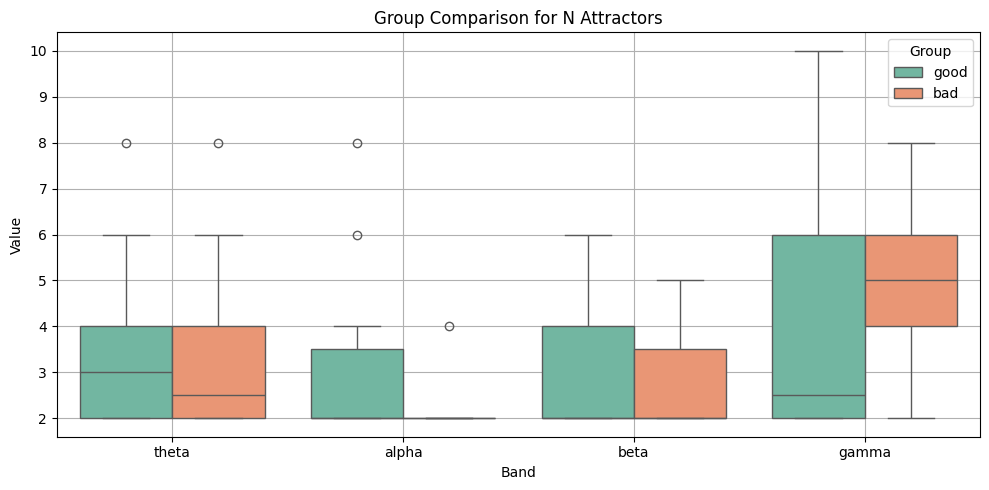

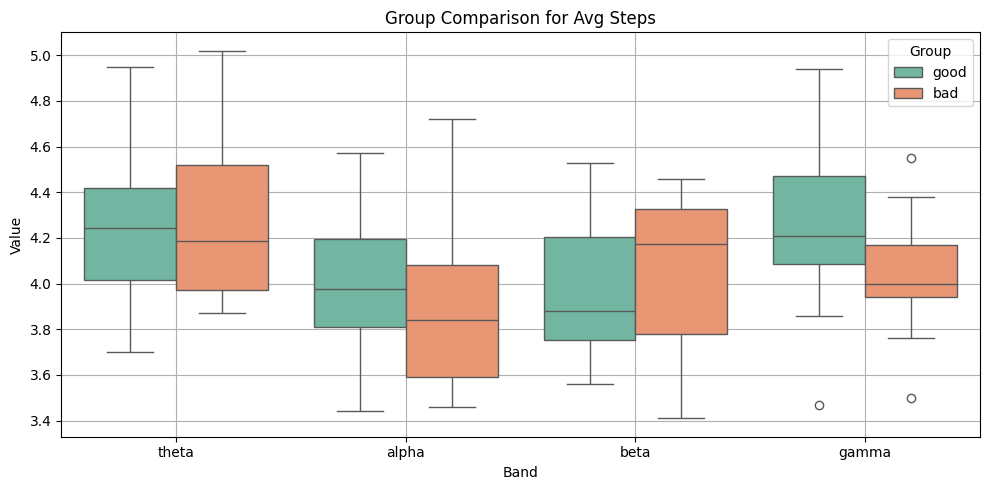

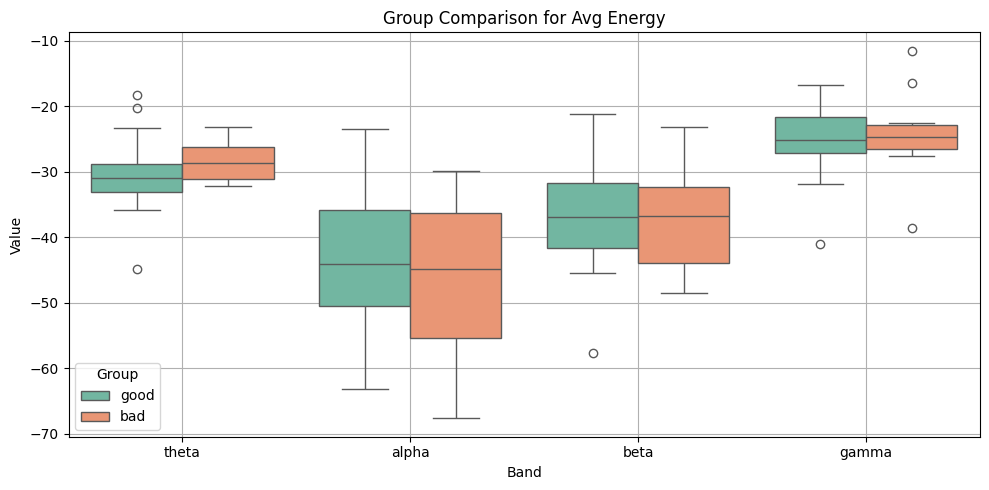

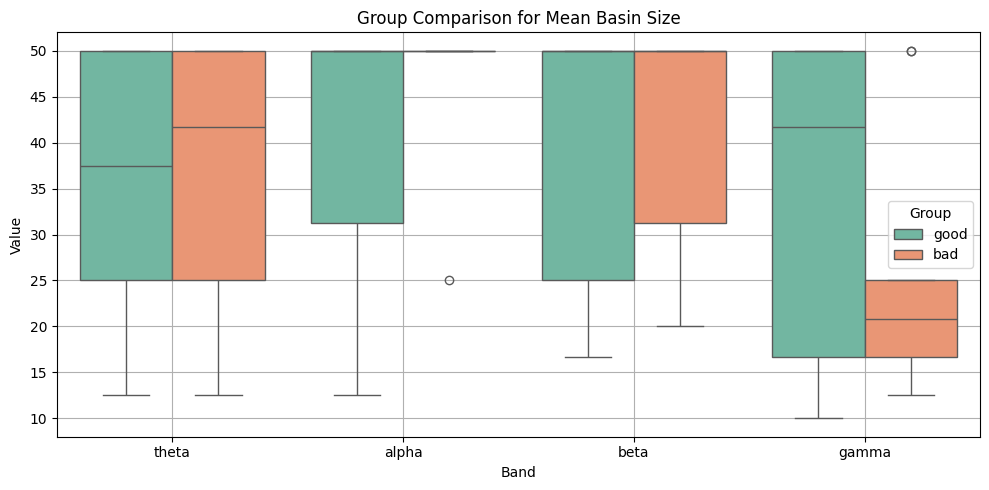

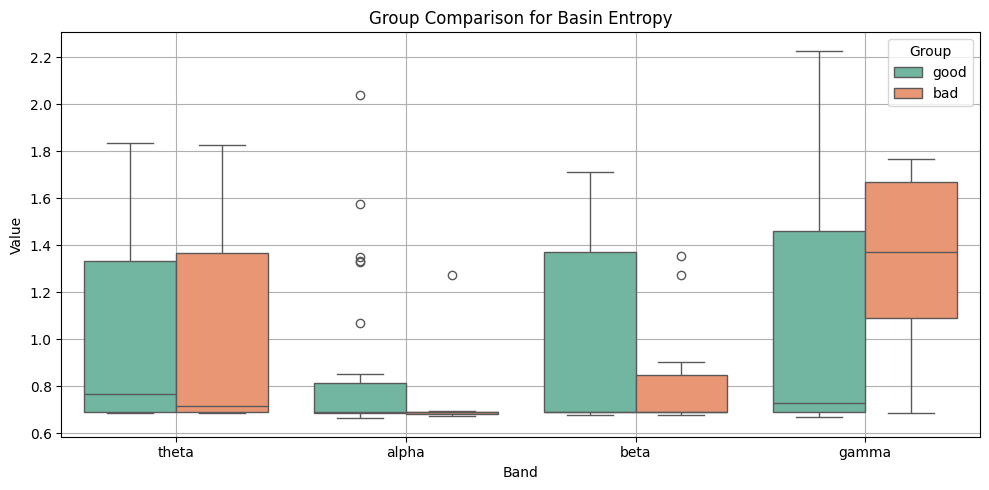

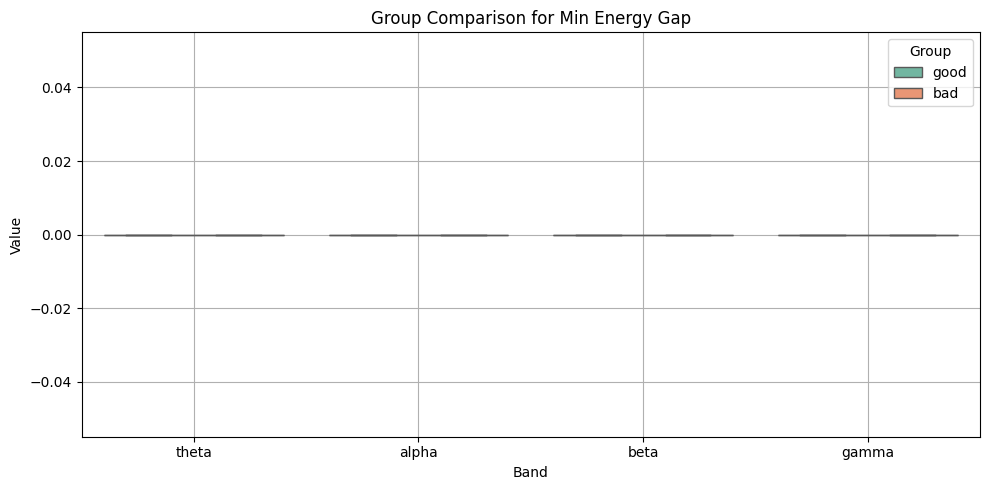

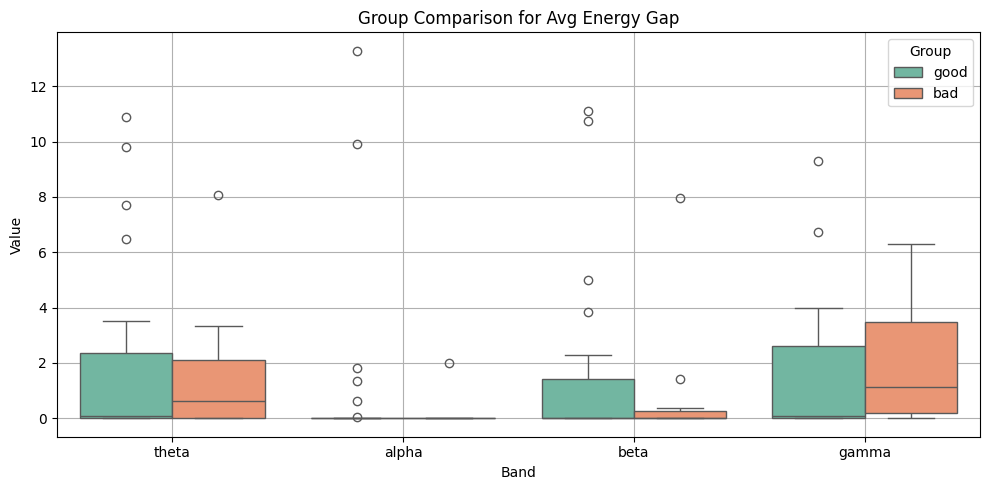

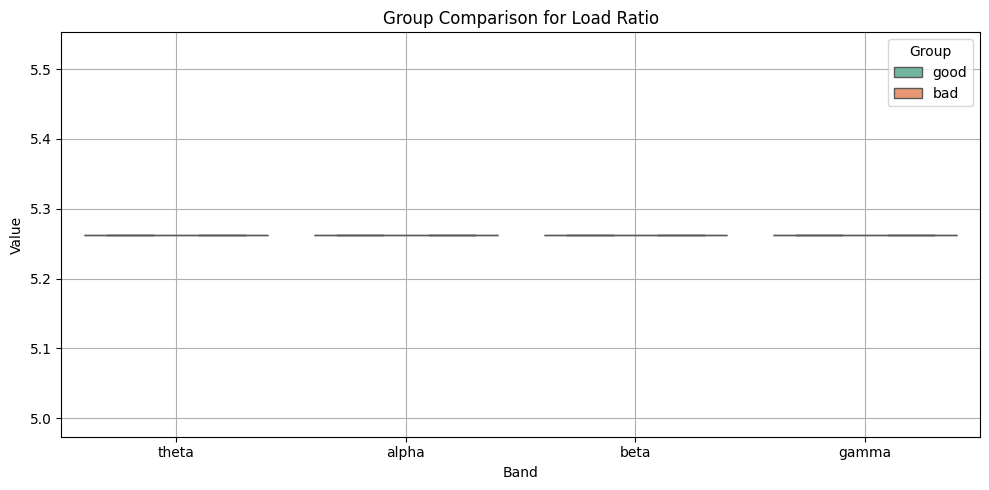

In [51]:
for metric in all_hopfield_metrics:
    plot_group_feature_distribution(features_by_group, metric)


In [52]:
import os

def plot_group_feature_distribution(features_by_group, metric, save_fig=False, out_dir="plots"):
    """
    Plot boxplots comparing a given Hopfield feature across groups and EEG bands.
    """
    records = []
    for group in ['good', 'bad']:
        for band in ['theta', 'alpha', 'beta', 'gamma']:
            values = features_by_group[group][band].get(metric, [])
            for v in values:
                records.append({'Group': group, 'Band': band, 'Value': v})

    df = pd.DataFrame(records)

    if df.empty:
        print(f"⚠️ No data found for metric: {metric}")
        return

    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Band', y='Value', hue='Group', data=df, palette='Set2')
    plt.title(f"📊 {metric.replace('_', ' ').title()} across EEG Bands")
    plt.grid(True)
    plt.tight_layout()

    if save_fig:
        os.makedirs(out_dir, exist_ok=True)
        plt.savefig(f"{out_dir}/{metric}.png", dpi=300)
        print(f"✅ Saved: {out_dir}/{metric}.png")
    plt.show()


/tmp/ipykernel_2111722/230264709.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/donaf-strange/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


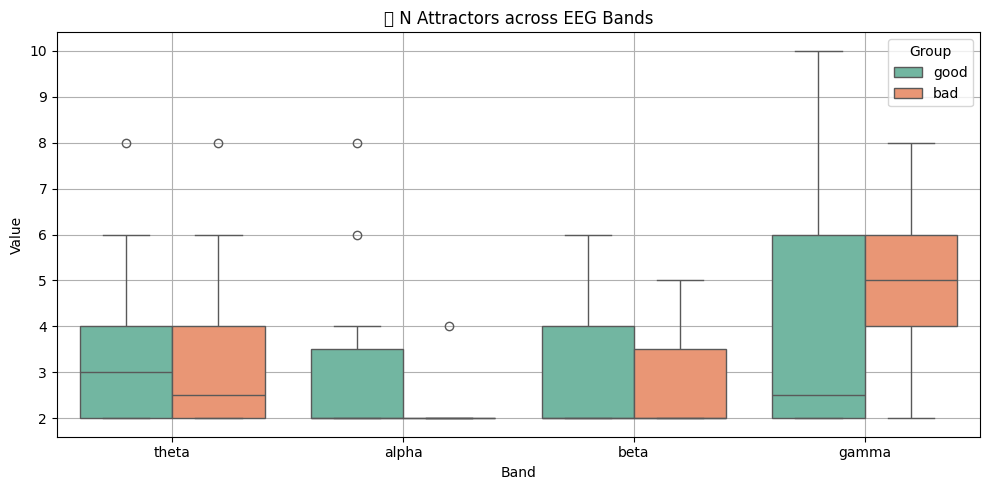

/tmp/ipykernel_2111722/230264709.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/donaf-strange/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


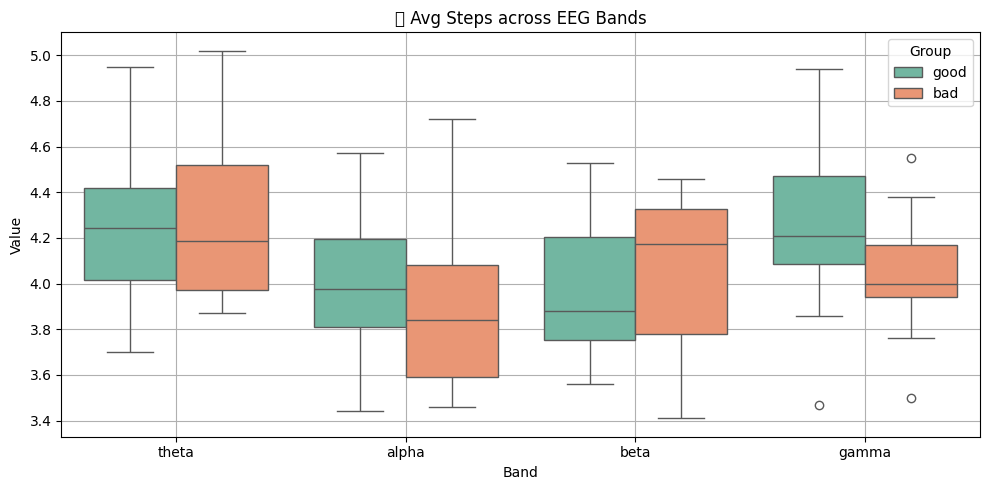

/tmp/ipykernel_2111722/230264709.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/donaf-strange/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


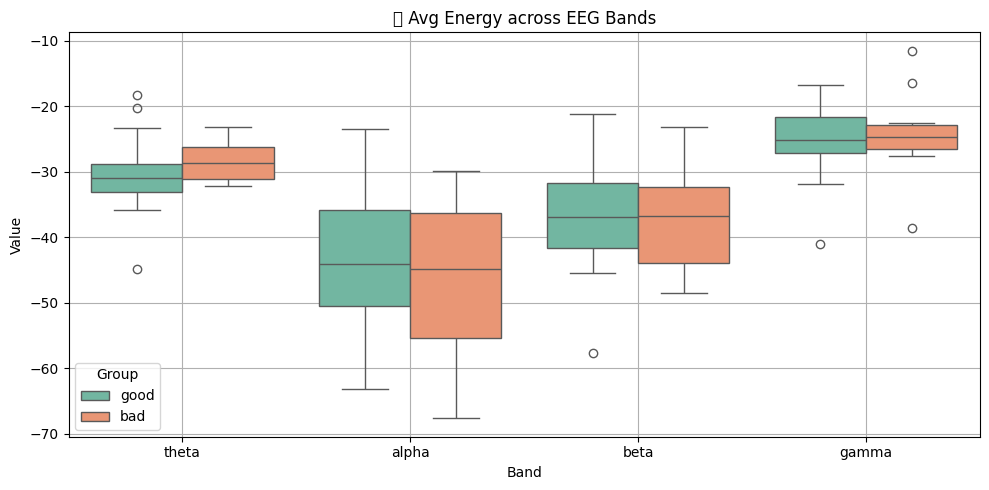

/tmp/ipykernel_2111722/230264709.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/donaf-strange/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


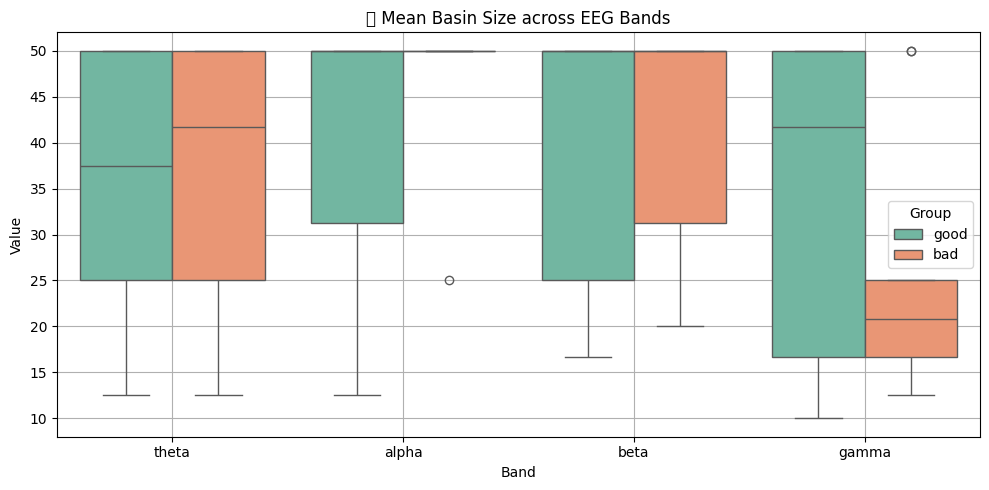

/tmp/ipykernel_2111722/230264709.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/donaf-strange/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


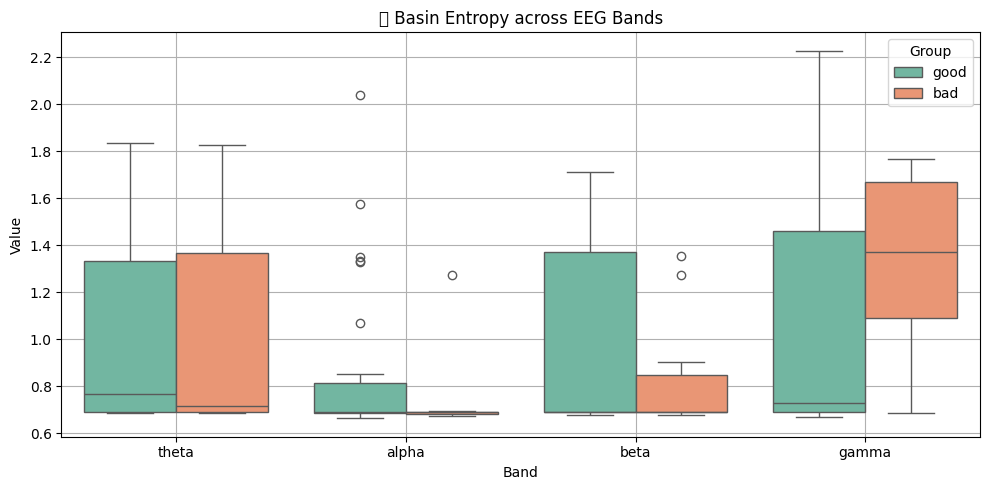

/tmp/ipykernel_2111722/230264709.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/donaf-strange/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


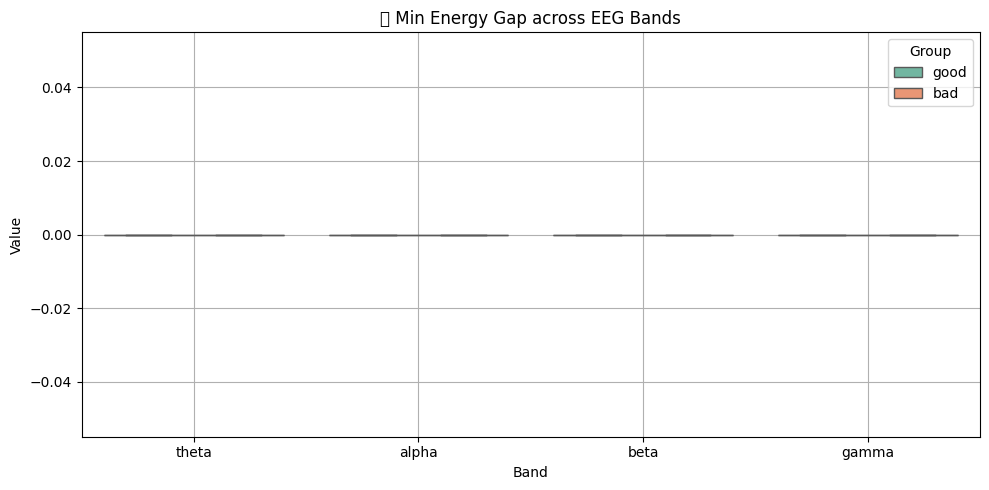

/tmp/ipykernel_2111722/230264709.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/donaf-strange/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


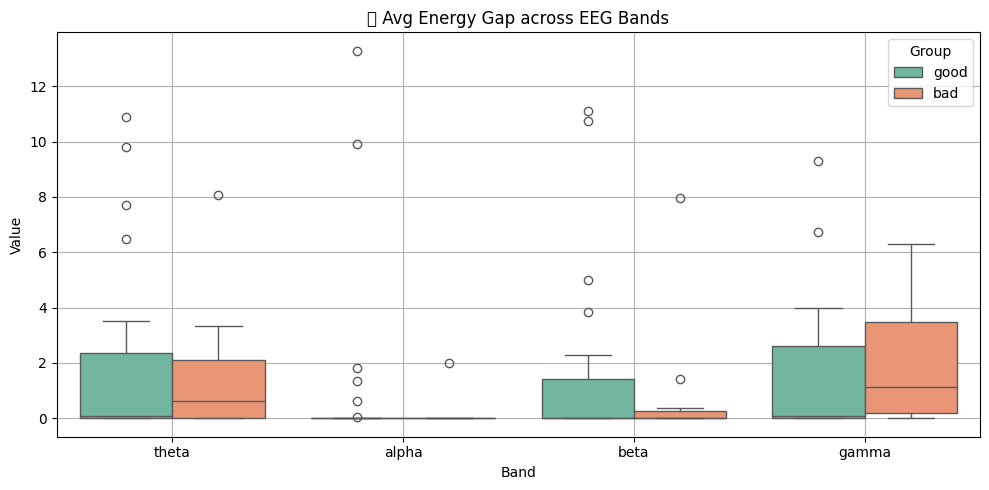

/tmp/ipykernel_2111722/230264709.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/donaf-strange/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


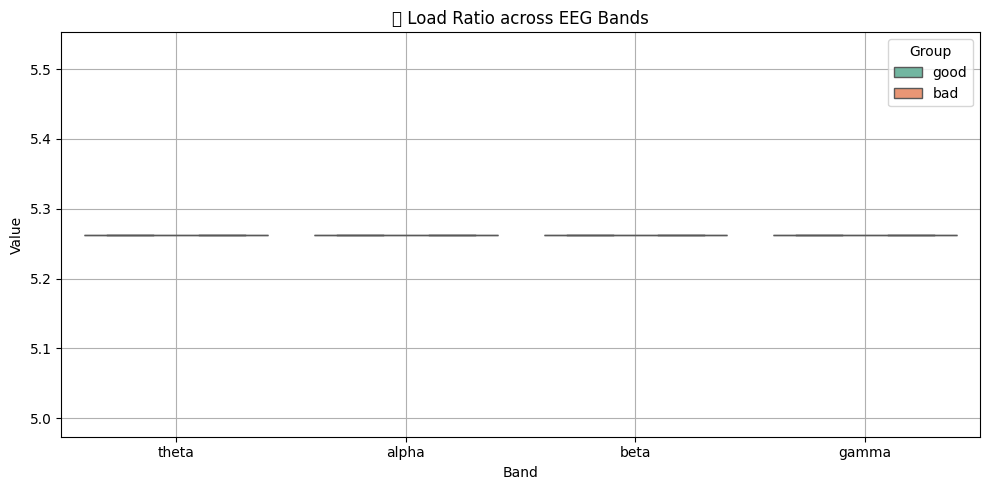

In [53]:
all_hopfield_metrics = [
    'n_attractors', 'avg_steps', 'avg_energy',
    'mean_basin_size', 'basin_entropy',
    'min_energy_gap', 'avg_energy_gap', 'load_ratio'
]

for metric in all_hopfield_metrics:
    plot_group_feature_distribution(features_by_group, metric)


## Classification using Hopfield Features

In [97]:
import numpy as np

def prepare_classification_data(features_by_group, bands=['theta', 'alpha', 'beta', 'gamma']):
    """
    Create feature matrix X and label vector y.
    Each row = one subject × band
    """
    rows = []
    for group_label, group in enumerate(['good', 'bad']):  # good → 0, bad → 1
        for subj_idx in range(len(features_by_group[group]['theta']['n_attractors'])):
            for band in bands:
                try:
                    row = {
                        'label': group_label,
                        'band': band,
                    }
                    for metric in all_hopfield_metrics:
                        values = features_by_group[group][band].get(metric, [])
                        if subj_idx < len(values):
                            row[metric] = values[subj_idx]
                        else:
                            row[metric] = np.nan
                    rows.append(row)
                except Exception as e:
                    print(f"⚠️ Error processing subject {subj_idx} in {group}-{band}: {e}")
    return pd.DataFrame(rows)

df = prepare_classification_data(features_by_group)
df = df.dropna()  # remove any rows with missing values


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Encode band as one-hot
df_encoded = pd.get_dummies(df, columns=['band'])

X = df_encoded.drop('label', axis=1).values
y = df_encoded['label'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79        33
           1       0.33      0.27      0.30        11

    accuracy                           0.68        44
   macro avg       0.55      0.55      0.55        44
weighted avg       0.66      0.68      0.67        44

📉 Confusion Matrix:
[[27  6]
 [ 8  3]]


/tmp/ipykernel_2111722/1539819678.py:10: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/donaf-strange/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


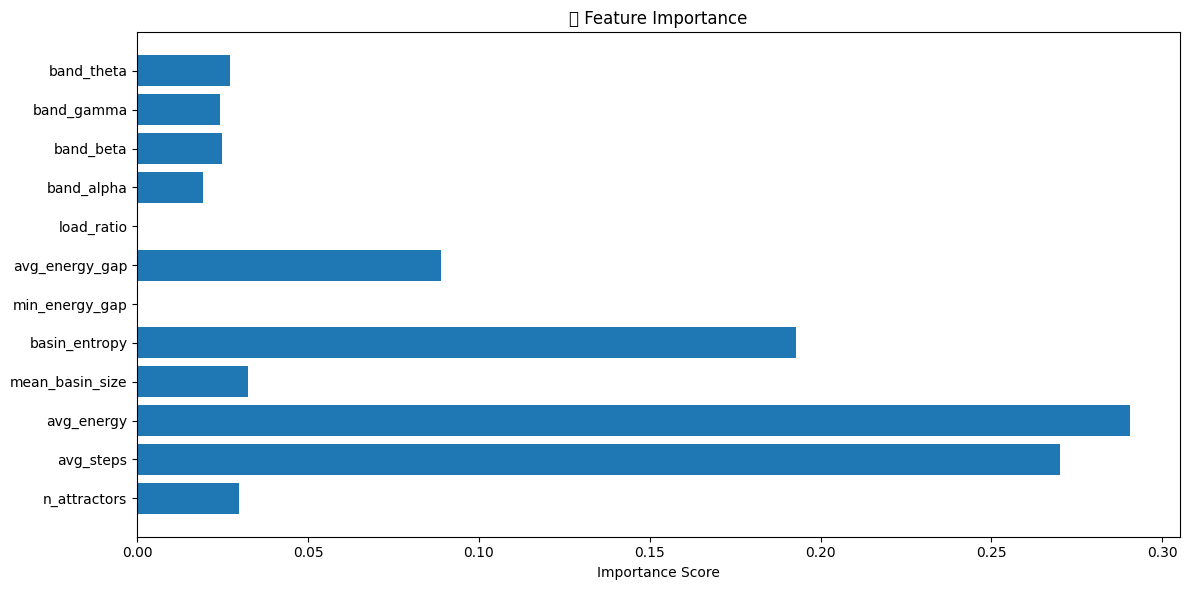

In [99]:
import matplotlib.pyplot as plt

feat_names = df_encoded.drop('label', axis=1).columns
importances = clf.feature_importances_

plt.figure(figsize=(12, 6))
plt.barh(feat_names, importances)
plt.title("🎯 Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [105]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.70      0.71        33
           1       0.17      0.18      0.17        11

    accuracy                           0.57        44
   macro avg       0.44      0.44      0.44        44
weighted avg       0.58      0.57      0.57        44

[[23 10]
 [ 9  2]]


In [101]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [102]:
y_pred = clf.predict(X_test)

In [103]:
from sklearn.metrics import classification_report, confusion_matrix

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        33
           1       0.25      0.18      0.21        11

    accuracy                           0.66        44
   macro avg       0.50      0.50      0.50        44
weighted avg       0.62      0.66      0.64        44


📉 Confusion Matrix:
[[27  6]
 [ 9  2]]


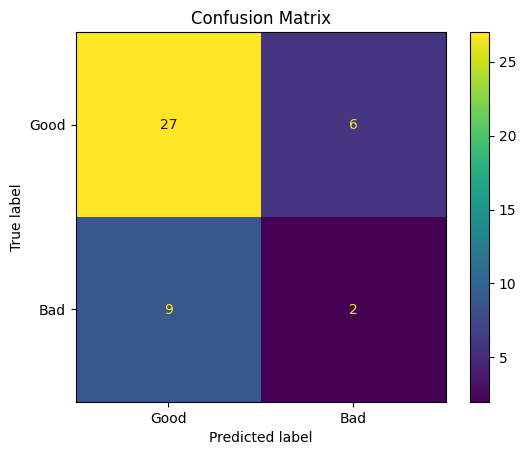

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Good', 'Bad'])
plt.title("Confusion Matrix")
plt.show()



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74        26
           1       0.00      0.00      0.00        10

    accuracy                           0.58        36
   macro avg       0.34      0.40      0.37        36
weighted avg       0.49      0.58      0.53        36


📉 Confusion Matrix:
[[21  5]
 [10  0]]

🔎 Top 10 Important Features:
feature_1     0.278174
feature_2     0.271310
feature_4     0.194198
feature_6     0.099648
feature_0     0.035917
feature_11    0.028508
feature_3     0.025790
feature_8     0.023221
feature_10    0.021989
feature_9     0.021245
dtype: float64


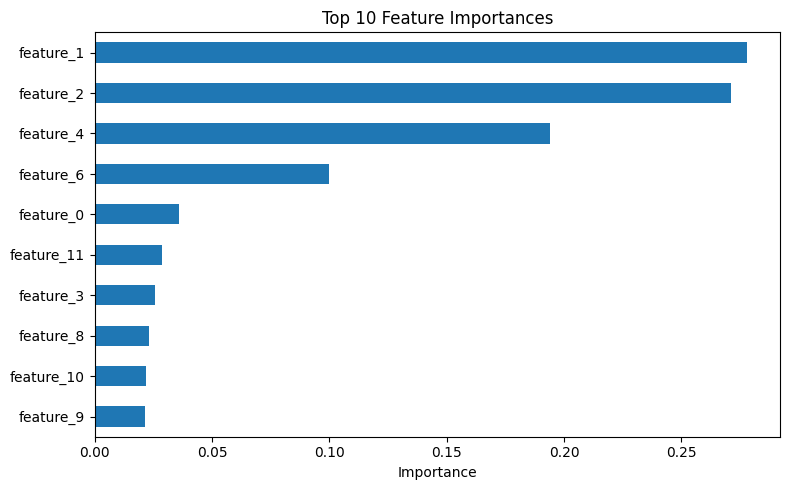

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------
# STEP 1: Prepare Data
# ----------------------

# Assuming you already have your features and labels:
# X = features (as DataFrame or array)
# y = labels (0 for good, 1 for bad)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# ----------------------
# STEP 2: Train Classifier
# ----------------------

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# ----------------------
# STEP 3: Evaluate
# ----------------------

y_pred = clf.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ----------------------
# STEP 4: Feature Importance
# ----------------------

# Feature names
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
importances = clf.feature_importances_

# Create Series and plot
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("\n🔎 Top 10 Important Features:")
print(feat_imp.head(10))

# Plot top 10
feat_imp.head(10).plot(kind='barh', title='Top 10 Feature Importances', figsize=(8, 5))
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [63]:
def flatten_hopfield_features(hopfield_feats, subject_ids=None):
    """
    Flatten nested Hopfield feature dictionary into a tabular format.
    Returns:
        - X: DataFrame of shape (n_subjects, n_features)
        - y: Labels (0=bad, 1=good)
    """
    all_rows = []
    all_subjects = list(hopfield_feats.keys()) if subject_ids is None else subject_ids
    bands = ['theta', 'alpha', 'beta', 'gamma']
    features = [
        'n_attractors', 'avg_steps', 'avg_energy',
        'mean_basin_size', 'basin_entropy',
        'min_energy_gap', 'avg_energy_gap', 'load_ratio'
    ]

    for sid in all_subjects:
        row = {}
        if sid not in hopfield_feats:
            continue
        for band in bands:
            if band not in hopfield_feats[sid]:
                continue
            for feat in features:
                value = hopfield_feats[sid][band].get(feat, np.nan)
                row[f"{band}_{feat}"] = value
        row["subject_id"] = sid
        row["label"] = 1 if sid in good_counters else 0  # good = 1, bad = 0
        all_rows.append(row)

    df = pd.DataFrame(all_rows).set_index("subject_id")
    df = df.dropna(axis=0)  # Drop subjects with missing features
    return df.drop(columns="label"), df["label"]


In [64]:
def build_X_y_from_features(features_by_group, metrics, bands):
    """
    Convert nested feature dictionary into feature matrix X and labels y.
    Output:
        - X: shape (n_samples, n_features)
        - y: binary labels: 0=good, 1=bad
    """
    X = []
    y = []
    feature_names = []

    for group_label, group in enumerate(['good', 'bad']):
        for subj_idx in range(len(features_by_group[group][bands[0]][metrics[0]])):
            feature_vector = []
            for band in bands:
                for metric in metrics:
                    try:
                        value = features_by_group[group][band][metric][subj_idx]
                    except IndexError:
                        value = np.nan
                    feature_vector.append(value)
            X.append(feature_vector)
            y.append(group_label)

    feature_names = [f"{band}_{metric}" for band in bands for metric in metrics]
    return np.array(X), np.array(y), feature_names


In [65]:
# Set your desired bands and metrics
band_list = ['theta', 'alpha', 'beta', 'gamma']
metric_list = [
    'n_attractors', 'avg_steps', 'avg_energy',
    'mean_basin_size', 'basin_entropy',
    'min_energy_gap', 'avg_energy_gap', 'load_ratio'
]

# Build X and y
X, y, feature_names = build_X_y_from_features(features_by_group, metric_list, band_list)

# Now build the DataFrame
X_df = pd.DataFrame(X, columns=feature_names)


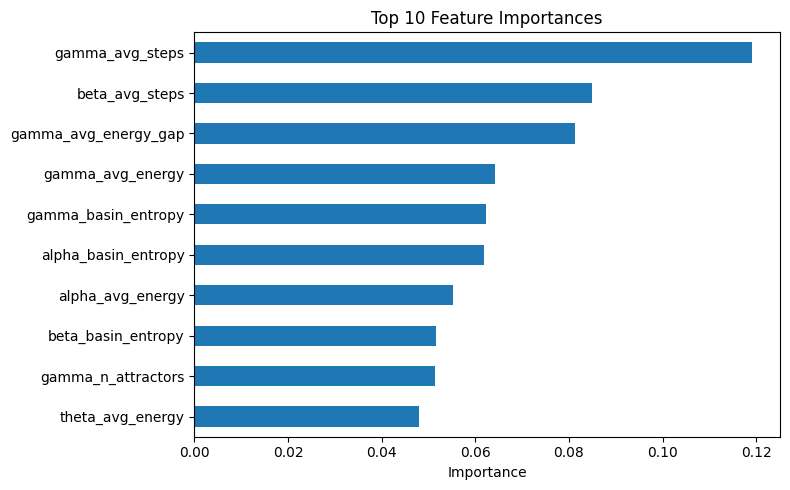

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_df, y, stratify=y, test_size=0.25, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Feature importance
importances = clf.feature_importances_
feat_imp = pd.Series(importances, index=X_df.columns).sort_values(ascending=False)

# Plot
feat_imp.head(10).plot(kind='barh', title='Top 10 Feature Importances', figsize=(8, 5))
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [72]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_attractors_pca(hopfield_feats, patterns_all, subject_id='12', band='alpha', n_init=100):
    """
    Run Hopfield dynamics and plot final attractors in PCA space.
    """
    patterns = patterns_all[subject_id][band]
    n_patterns, n_units = patterns.shape

    # Train the Hopfield model
    model = HopfieldNetwork(n_units)
    model.train_hebbian(patterns)

    # Run dynamics from random initial states
    init_states = np.random.choice([-1, 1], size=(n_init, n_units))
    stable_states, _, _ = model.run_multiple(init_states)

    # Convert to array and count attractors
    stable_states = np.array(stable_states)
    attractor_tuples = [tuple(s) for s in stable_states]
    counts = Counter(attractor_tuples)
    unique_states = np.array(list(counts.keys()))
    sizes = np.array(list(counts.values()))

    # PCA projection to 2D
    pca = PCA(n_components=2)
    proj = pca.fit_transform(unique_states)

    # Plot
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(proj[:, 0], proj[:, 1], s=sizes*10, c=sizes, cmap='viridis', edgecolor='k')
    plt.colorbar(scatter, label="Basin Size")
    plt.title(f"PCA of Attractors - Subject {subject_id} | {band.upper()}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [67]:
from collections import Counter

def plot_basin_histogram(hopfield_feats, patterns_dict, subject_id, band):
    patterns = patterns_dict[subject_id][band]
    model = HopfieldNetwork(n_units=patterns.shape[1])
    model.train_hebbian(patterns)

    stable_states, _, _ = model.run_multiple(patterns)
    attractors = [tuple(s) for s in stable_states]
    basin_sizes = Counter(attractors).values()

    plt.figure(figsize=(6, 4))
    plt.hist(basin_sizes, bins=range(1, max(basin_sizes)+2), edgecolor='black')
    plt.title(f"Basin Sizes | Subject {subject_id}, Band: {band}")
    plt.xlabel("Size of Basin")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


In [74]:
import matplotlib.pyplot as plt

def plot_energy_trajectories(hopfield_feats, patterns_all, subject_id='12', band='alpha'):
    """
    Plot energy trajectories for a given subject and band.
    """
    patterns = patterns_all[subject_id][band]
    n_patterns, n_units = patterns.shape

    # Re-train Hopfield network
    model = HopfieldNetwork(n_units)
    model.train_hebbian(patterns)

    # Run dynamics
    init_states = patterns[:10]  # or random subset
    _, _, energy_traces = model.run_multiple(init_states)

    # Plot energy over time for each run
    plt.figure(figsize=(8, 5))
    for traj in energy_traces:
        plt.plot(traj, alpha=0.6)
    plt.xlabel("Step")
    plt.ylabel("Energy")
    plt.title(f"Energy Trajectories - Subject {subject_id} | {band.upper()}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


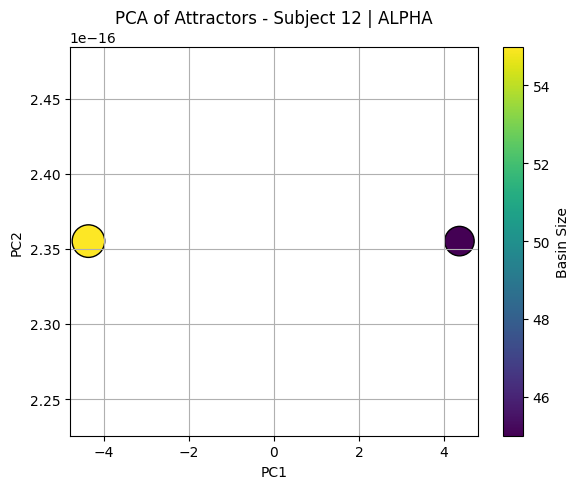

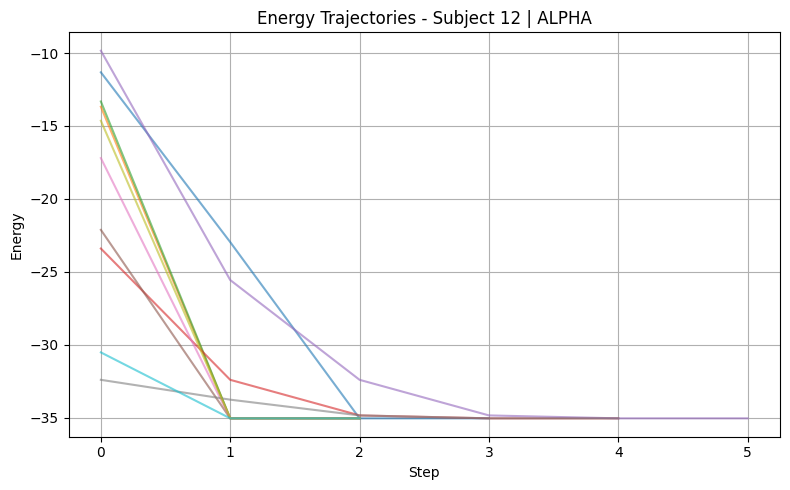

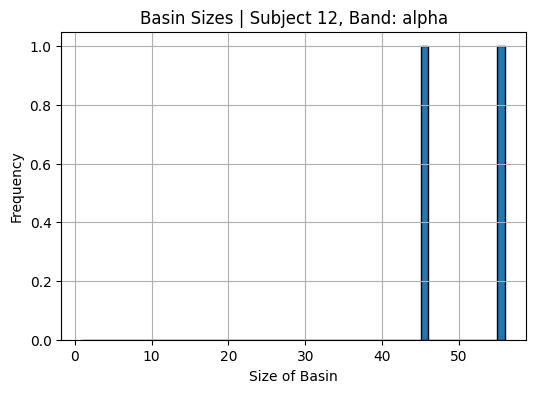

In [77]:
plot_attractors_pca(hopfield_feats_rest, patterns_rest, subject_id='12', band='alpha')

plot_energy_trajectories(hopfield_feats_rest, patterns_rest, subject_id='12', band='alpha')

plot_basin_histogram(hopfield_feats_rest, patterns_rest, subject_id='12', band='alpha')


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_energy_landscape(hopfield_model, n_units, band_name, subject_id):
    """
    Visualizes energy landscape using PCA on all binary states.
    """
    # All possible binary states
    all_states = all_binary_states(n_units)  # shape: (2^n, n)
    energies = np.array([hopfield_model.energy(s) for s in all_states])

    # Dimensionality reduction for visualization
    pca = PCA(n_components=2)
    states_2d = pca.fit_transform(all_states)

    # Normalize energies for colormap
    norm_energies = (energies - energies.min()) / (energies.max() - energies.min())

    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(states_2d[:, 0], states_2d[:, 1],
                          c=norm_energies, cmap='viridis', s=30)
    plt.colorbar(scatter, label='Normalized Energy')
    plt.title(f"Energy Landscape\nSubject {subject_id}, Band: {band_name}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()


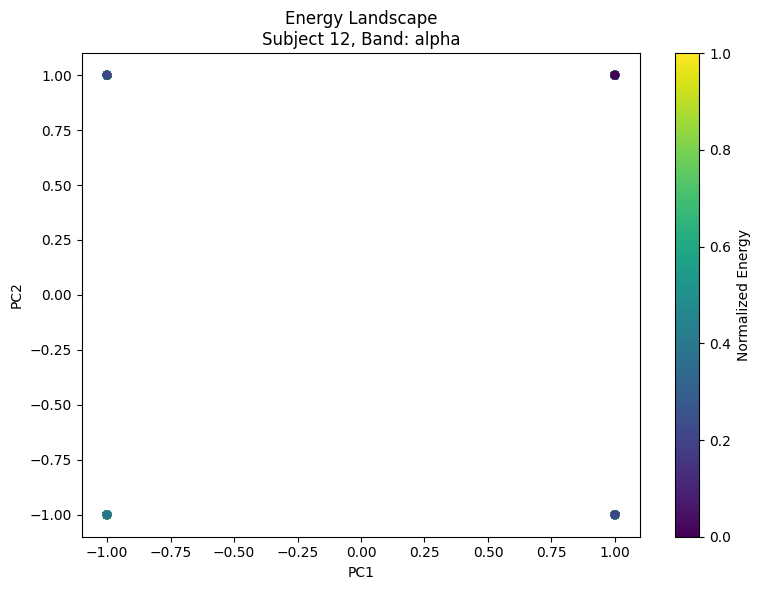

In [ ]:
subj_id = '12'
band = 'alpha'

# Extract patterns
patterns = patterns_rest[subj_id][band]
patterns = np.where(patterns == 0, -1, 1)

# Train model
model = HopfieldNetwork(n_units=patterns.shape[1])
model.train_hebbian(patterns)

# Visualize
visualize_energy_landscape(model, n_units=patterns.shape[1], band_name=band, subject_id=subj_id)


In [78]:
def compute_local_curvature(hopfield_model, n_units):
    """
    Compute discrete curvature for each binary state in {-1, +1}^n.
    Curvature = sum of energy differences between a state and its Hamming neighbors.

    Returns:
        state_energy: list of energies
        curvature: list of curvature values (same order as states)
    """
    all_states = all_binary_states(n_units)  # shape: (2^n, n)
    state_energy = []
    curvature = []

    for i, s in enumerate(all_states):
        e_s = hopfield_model.energy(s)
        state_energy.append(e_s)

        # Hamming neighbors
        neighbors = []
        for j in range(n_units):
            neighbor = s.copy()
            neighbor[j] *= -1
            neighbors.append(neighbor)

        energy_diffs = [hopfield_model.energy(n) - e_s for n in neighbors]
        kappa = sum(energy_diffs)
        curvature.append(kappa)

    return np.array(state_energy), np.array(curvature)


In [80]:
# Load patterns for subject '12' and band 'alpha'
patterns = patterns_rest['12']['alpha']

In [81]:
model = HopfieldNetwork(n_units=patterns.shape[1])
model.train_hebbian(patterns)

state_energy, curvature = compute_local_curvature(model, n_units=patterns.shape[1])


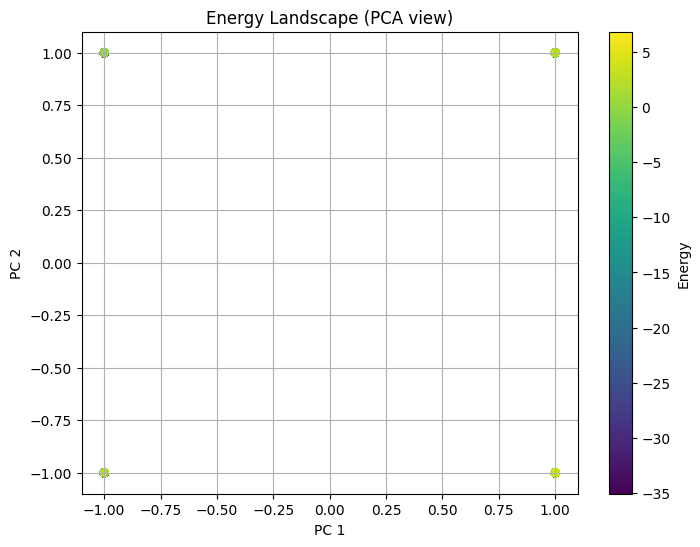

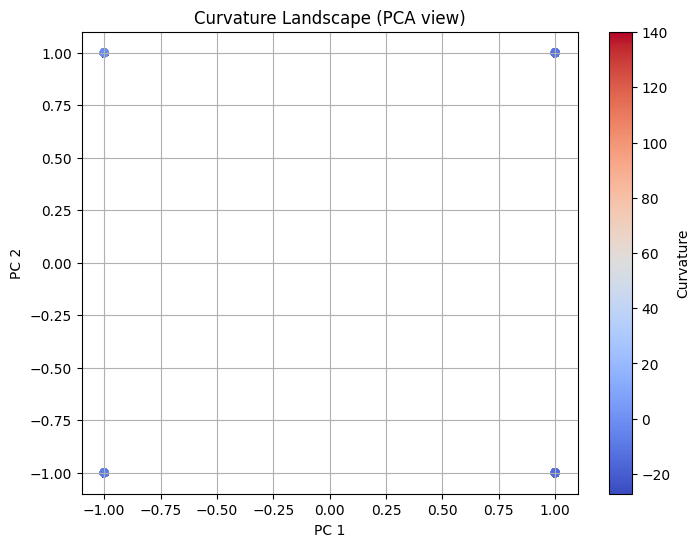

In [82]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Get all states
states = all_binary_states(patterns.shape[1])  # shape: (2^n, n)

# 2. Embed into 2D using PCA
pca = PCA(n_components=2)
xy = pca.fit_transform(states)

# 3. Plot: Energy landscape
plt.figure(figsize=(8, 6))
plt.scatter(xy[:, 0], xy[:, 1], c=state_energy, cmap='viridis', s=30)
plt.colorbar(label="Energy")
plt.title("Energy Landscape (PCA view)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()

# 4. Plot: Curvature landscape
plt.figure(figsize=(8, 6))
plt.scatter(xy[:, 0], xy[:, 1], c=curvature, cmap='coolwarm', s=30)
plt.colorbar(label="Curvature")
plt.title("Curvature Landscape (PCA view)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()


In [83]:
for subj in patterns_rest:
    for band in patterns_rest[subj]:
        print(subj, band, patterns_rest[subj][band].shape)


0 theta (100, 19)
0 alpha (100, 19)
0 beta (100, 19)
0 gamma (100, 19)
29 theta (100, 19)
29 alpha (100, 19)
29 beta (100, 19)
29 gamma (100, 19)
14 theta (100, 19)
14 alpha (100, 19)
14 beta (100, 19)
14 gamma (100, 19)
5 theta (100, 19)
5 alpha (100, 19)
5 beta (100, 19)
5 gamma (100, 19)
2 theta (100, 19)
2 alpha (100, 19)
2 beta (100, 19)
2 gamma (100, 19)
12 theta (100, 19)
12 alpha (100, 19)
12 beta (100, 19)
12 gamma (100, 19)
17 theta (100, 19)
17 alpha (100, 19)
17 beta (100, 19)
17 gamma (100, 19)
25 theta (100, 19)
25 alpha (100, 19)
25 beta (100, 19)
25 gamma (100, 19)
10 theta (100, 19)
10 alpha (100, 19)
10 beta (100, 19)
10 gamma (100, 19)
3 theta (100, 19)
3 alpha (100, 19)
3 beta (100, 19)
3 gamma (100, 19)
19 theta (100, 19)
19 alpha (100, 19)
19 beta (100, 19)
19 gamma (100, 19)
4 theta (100, 19)
4 alpha (100, 19)
4 beta (100, 19)
4 gamma (100, 19)
8 theta (100, 19)
8 alpha (100, 19)
8 beta (100, 19)
8 gamma (100, 19)
18 theta (100, 19)
18 alpha (100, 19)
18 beta (10

In [84]:
patterns = patterns_rest['29']['theta']


In [85]:
# Train model
model = HopfieldNetwork(n_units=patterns.shape[1])
model.train_hebbian(patterns)

# Compute all binary states
states = all_binary_states(patterns.shape[1])  # (524288, 19)

# Compute energy and curvature
state_energy = np.array([model.energy(s) for s in states])

from scipy.spatial import distance_matrix
from scipy.sparse import csgraph

def compute_local_curvature(model, n_units):
    states = all_binary_states(n_units)
    energy = np.array([model.energy(s) for s in states])
    curvature = []
    for i, s in enumerate(states):
        neighbors = [s ^ (1 << j) for j in range(n_units)]  # Hamming neighbors
        e0 = energy[i]
        en = [model.energy(states[j]) for j in neighbors]
        lap = sum(en) - len(neighbors) * e0
        curvature.append(lap)
    return np.array(curvature)

# Optional: downsample for faster processing
subset_idx = np.random.choice(len(states), size=3000, replace=False)
states_sample = states[subset_idx]
energy_sample = state_energy[subset_idx]


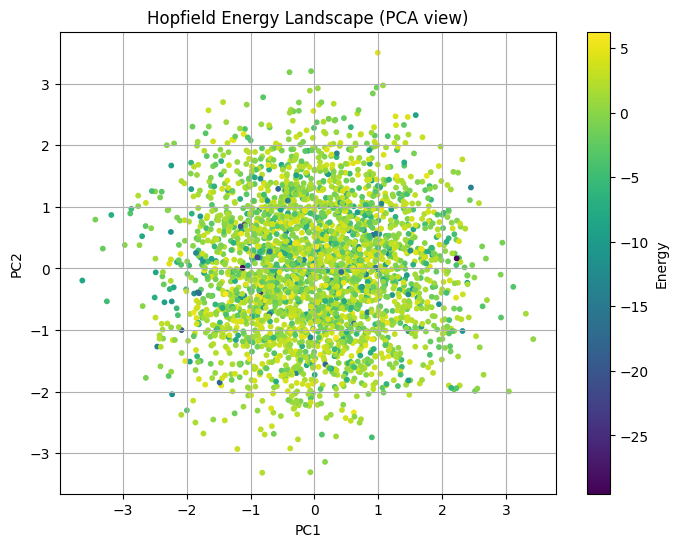

In [86]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
xy = pca.fit_transform(states_sample)

plt.figure(figsize=(8, 6))
plt.scatter(xy[:, 0], xy[:, 1], c=energy_sample, cmap='viridis', s=10)
plt.colorbar(label="Energy")
plt.title("Hopfield Energy Landscape (PCA view)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [87]:
from sklearn.decomposition import PCA
from tqdm import tqdm

def energy_landscape_features(patterns_dict, max_states=2**19):
    features = {}
    
    for subj_id in tqdm(patterns_dict):
        features[subj_id] = {}
        for band in patterns_dict[subj_id]:
            patterns = patterns_dict[subj_id][band]
            n_units = patterns.shape[1]

            try:
                # Train Hopfield
                model = HopfieldNetwork(n_units)
                model.train_hebbian(patterns)

                # All states
                states = all_binary_states(n_units)
                energies = np.array([model.energy(s) for s in states])

                # PCA reduction
                pca = PCA(n_components=2)
                coords = pca.fit_transform(states)

                # Store summary
                features[subj_id][band] = {
                    'mean_energy': float(np.mean(energies)),
                    'min_energy': float(np.min(energies)),
                    'max_energy': float(np.max(energies)),
                    'energy_std': float(np.std(energies)),
                    'energy_range': float(np.ptp(energies))
                }

            except Exception as e:
                print(f"❌ {subj_id} {band} failed: {e}")
                continue

    return features


In [88]:
landscape_feats_rest = energy_landscape_features(patterns_rest)


100%|██████████| 36/36 [04:08<00:00,  6.89s/it]


In [89]:
from collections import defaultdict
from scipy.stats import ttest_ind

def groupwise_energy_features(feats, good_ids, bad_ids, bands, metrics):
    grouped = {'good': defaultdict(list), 'bad': defaultdict(list)}

    for group, ids in [('good', good_ids), ('bad', bad_ids)]:
        for sid in ids:
            sid = str(sid)
            if sid not in feats:
                continue
            for band in bands:
                if band in feats[sid]:
                    for metric in metrics:
                        val = feats[sid][band].get(metric, None)
                        if val is not None and not np.isnan(val):
                            grouped[group][f"{band}_{metric}"].append(val)
    return grouped

# Define groups
good_ids = ['1','2','3','5','7','8','11','12','13','15','16','17','18','20','23','24','25','26','27','28','29','31','32','33','34','35']
bad_ids  = ['0','4','6','9','10','14','19','21','22','30']

metrics = ['mean_energy', 'min_energy', 'max_energy', 'energy_std', 'energy_range']
bands = ['theta', 'alpha', 'beta', 'gamma']

grouped_energy_feats = groupwise_energy_features(landscape_feats_rest, good_ids, bad_ids, bands, metrics)


In [93]:
def compare_grouped_features(grouped_feats):
    for metric in grouped_feats['good']:
        good = grouped_feats['good'][metric]
        bad  = grouped_feats['bad'][metric]
        if len(good) > 1 and len(bad) > 1:
            t, p = ttest_ind(good, bad, equal_var=False)
            print(f"📊 {metric.upper()}")
            print(f"   ➤ Good mean: {np.mean(good):.2f}")
            print(f"   ➤ Bad  mean: {np.mean(bad):.2f}")
            print(f"   ➤ t = {t:.2f}, p = {p:.4f}\n")
        else:
            print(f"⚠️ Skipping {metric} due to insufficient data.")

compare_grouped_features(grouped_energy_feats)


📊 THETA_MEAN_ENERGY
   ➤ Good mean: 0.00
   ➤ Bad  mean: 0.00
   ➤ t = 0.06, p = 0.9515

📊 THETA_MIN_ENERGY
   ➤ Good mean: -30.78
   ➤ Bad  mean: -28.79
   ➤ t = -1.31, p = 0.2013

📊 THETA_MAX_ENERGY
   ➤ Good mean: 6.83
   ➤ Bad  mean: 6.90
   ➤ t = -0.60, p = 0.5565

📊 THETA_ENERGY_STD
   ➤ Good mean: 3.72
   ➤ Bad  mean: 3.62
   ➤ t = 0.76, p = 0.4576

📊 THETA_ENERGY_RANGE
   ➤ Good mean: 37.60
   ➤ Bad  mean: 35.69
   ➤ t = 1.21, p = 0.2369

📊 ALPHA_MEAN_ENERGY
   ➤ Good mean: 0.00
   ➤ Bad  mean: -0.00
   ➤ t = 1.21, p = 0.2474

📊 ALPHA_MIN_ENERGY
   ➤ Good mean: -43.73
   ➤ Bad  mean: -46.64
   ➤ t = 0.64, p = 0.5343

📊 ALPHA_MAX_ENERGY
   ➤ Good mean: 7.24
   ➤ Bad  mean: 7.26
   ➤ t = -0.14, p = 0.8916

📊 ALPHA_ENERGY_STD
   ➤ Good mean: 4.69
   ➤ Bad  mean: 4.79
   ➤ t = -0.29, p = 0.7749

📊 ALPHA_ENERGY_RANGE
   ➤ Good mean: 50.97
   ➤ Bad  mean: 53.90
   ➤ t = -0.63, p = 0.5402

📊 BETA_MEAN_ENERGY
   ➤ Good mean: -0.00
   ➤ Bad  mean: 0.00
   ➤ t = -0.75, p = 0.4630

📊 BETA

In [94]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grouped_feature_comparison(grouped_feats, figsize=(12, 6)):
    metrics = list(grouped_feats['good'].keys())
    metrics.sort()  # Sort to group same band together
    x = np.arange(len(metrics))  # x-axis positions
    
    # Prepare means and std
    good_means = [np.mean(grouped_feats['good'][m]) for m in metrics]
    bad_means  = [np.mean(grouped_feats['bad'][m]) for m in metrics]
    good_stds  = [np.std(grouped_feats['good'][m]) for m in metrics]
    bad_stds   = [np.std(grouped_feats['bad'][m]) for m in metrics]

    # Plot
    width = 0.35
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x - width/2, good_means, width, yerr=good_stds, capsize=5, label='Good', color='skyblue')
    ax.bar(x + width/2, bad_means, width, yerr=bad_stds, capsize=5, label='Bad', color='salmon')
    
    ax.set_ylabel('Feature Value')
    ax.set_title('Energy Landscape Feature Comparison (Good vs Bad)')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.show()


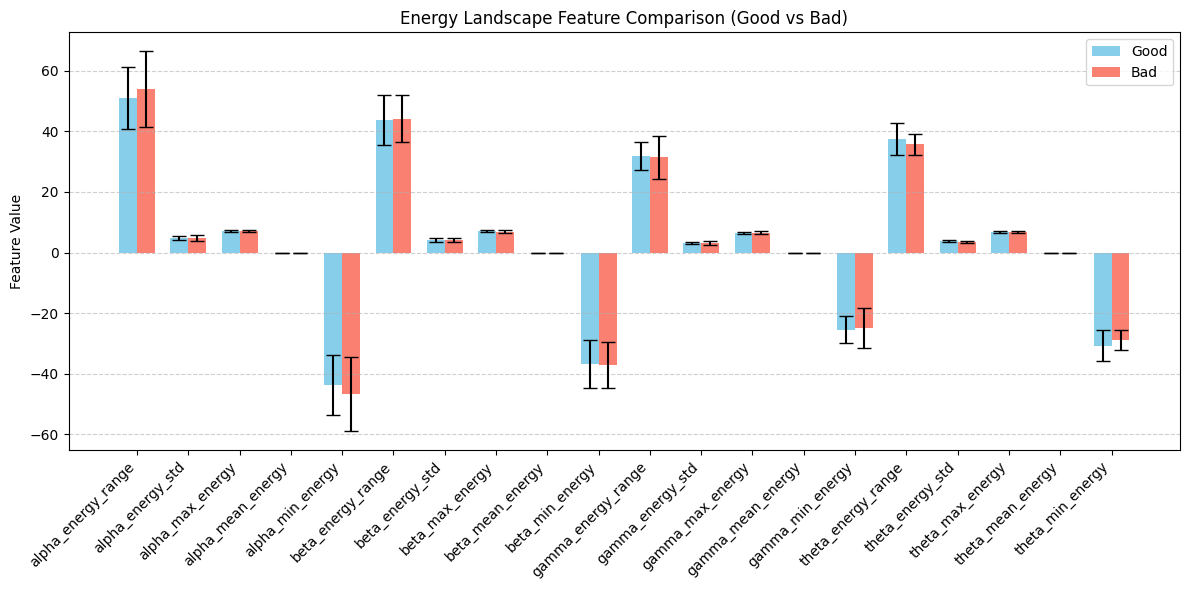

In [95]:
plot_grouped_feature_comparison(grouped_energy_feats)


## Deep Attractor Landscape Modeling

In [108]:
#nothing
2+2
3+3

6

Here is a description for each cell in your notebook:

---

### **Cell 1**
**Description:**  
Imports necessary libraries for EEG data processing, visualization, and Hopfield network implementation. Libraries include `pickle` for data loading, `mne` for EEG data handling, `numpy` for numerical operations, and others like `matplotlib`, `seaborn`, and `tqdm` for visualization and progress tracking.

---

### **Cell 2**
**Description:**  
Defines a function `all_binary_states(n)` to generate all possible binary states of length `n` in the set `{-1, +1}`. This is used for exploring the state space of the Hopfield network.

---

### **Cell 3**
**Description:**  
Loads the preprocessed binary EEG data (`binary_rest.pkl`) into the variable `binary_rest` using `pickle`.

---

### **Cell 4**
**Description:**  
Defines the function `extract_all_patterns` to extract binary EEG state patterns for all subjects and bands. It ensures the patterns are converted to bipolar format (`{-1, +1}`) and limits the number of patterns to `max_patterns` for computational efficiency.

---

### **Cell 5**
**Description:**  
Prints the shape of the extracted patterns for a specific subject (`'22'`) and band (`'beta'`) to verify the data structure.

---

### **Cell 6**
**Description:**  
Defines the `HopfieldNetwork` class, which implements a Hopfield network. It includes methods for:
- Training the network using Hebbian learning.
- Computing the energy of a state.
- Simulating asynchronous updates to find stable states.
- Running the network from multiple initial states.

---

### **Cell 7**
**Description:**  
Defines the `hopfield_features` function to compute Hopfield network features for each subject and band. Features include:
- Number of attractors.
- Average steps to convergence.
- Average energy of stable states.

---

### **Cell 8**
**Description:**  
Calls the `extract_all_patterns` function to extract patterns from the binary EEG data (`binary_rest`).

---

### **Cell 9**
**Description:**  
Checks the unique values in the extracted patterns for a specific subject (`'12'`) and band (`'alpha'`) to ensure the patterns are in the expected bipolar format (`{-1, +1}`).

---

### **Cell 10**
**Description:**  
Computes Hopfield network features for the extracted patterns (`patterns_rest`) using the `hopfield_features` function.

---

### **Cell 11**
**Description:**  
Loads binary EEG data, extracts patterns, computes Hopfield features, and prints an example of the computed features for a specific subject (`'12'`) and band (`'alpha'`).

---

### **Cell 12**
**Description:**  
Defines the `groupwise_hopfield_features` function to organize Hopfield features for group comparisons (e.g., good vs. bad subjects) across EEG bands.

---

### **Cell 13**
**Description:**  
Defines the good and bad subject groups using their IDs.

---

### **Cell 14**
**Description:**  
Organizes Hopfield features into group-wise structures for comparison between good and bad subjects.

---

### **Cell 15**
**Description:**  
Retrieves and prints the number of attractors for the good group in the `alpha` band.

---

### **Cell 16**
**Description:**  
Defines the `compare_group_feature` function to perform statistical comparisons (e.g., t-tests) between good and bad groups for a specific Hopfield feature and band.

---

### **Cell 17**
**Description:**  
Compares specific Hopfield features (`n_attractors`, `avg_steps`, `avg_energy`) between good and bad groups for different EEG bands.

---

### **Cell 18**
**Description:**  
Iterates through all Hopfield metrics and EEG bands to perform group comparisons and print the results.

---

### **Cell 19**
**Description:**  
Defines the `hopfield_features` function with additional metrics, such as basin entropy, energy gaps, and load ratio, for a more detailed analysis of Hopfield dynamics.

---

### **Cell 20**
**Description:**  
Extracts patterns and computes Hopfield features using the updated `hopfield_features` function.

---

### **Cell 21**
**Description:**  
Defines the `groupwise_hopfield_features` function with additional checks for missing or invalid data.

---

### **Cell 22**
**Description:**  
Organizes Hopfield features into group-wise structures for comparison, including additional metrics.

---

### **Cell 23**
**Description:**  
Defines a list of all Hopfield metrics and iterates through them to perform group comparisons for each EEG band.

---

### **Cell 24**
**Description:**  
Plots the distribution of a specific Hopfield metric across groups and EEG bands using boxplots.

---

### **Cell 25**
**Description:**  
Iterates through all Hopfield metrics and generates boxplots for each metric across groups and bands.

---

### **Cell 26**
**Description:**  
Defines a function to prepare data for classification by flattening Hopfield features into a tabular format.

---

### **Cell 27**
**Description:**  
Prepares the data for classification by creating a feature matrix (`X`) and label vector (`y`).

---

### **Cell 28**
**Description:**  
Trains a Random Forest classifier on the Hopfield features and evaluates its performance using a classification report and confusion matrix.

---

### **Cell 29**
**Description:**  
Plots the feature importance scores from the trained Random Forest classifier.

---

### **Cell 30**
**Description:**  
Applies SMOTE (Synthetic Minority Oversampling Technique) to balance the dataset and retrains the classifier.

---

### **Cell 31**
**Description:**  
Retrains the Random Forest classifier with class weights to handle imbalanced data.

---

### **Cell 32**
**Description:**  
Predicts the test set labels using the trained classifier.

---

### **Cell 33**
**Description:**  
Prints the classification report and confusion matrix for the test set predictions.

---

### **Cell 34**
**Description:**  
Plots the confusion matrix for the classification results.

---

### **Cell 35**
**Description:**  
Retrains the Random Forest classifier and evaluates its performance, including feature importance analysis.

---

### **Cell 36**
**Description:**  
Defines a function to flatten Hopfield features into a tabular format for classification.

---

### **Cell 37**
**Description:**  
Builds the feature matrix (`X`) and label vector (`y`) from the group-wise Hopfield features.

---

### **Cell 38**
**Description:**  
Trains a Random Forest classifier on the flattened Hopfield features and plots the top 10 most important features.

---

### **Cell 39**
**Description:**  
Defines a function to visualize attractors in PCA space for a specific subject and band.

---

### **Cell 40**
**Description:**  
Defines a function to plot the histogram of basin sizes for a specific subject and band.

---

### **Cell 41**
**Description:**  
Defines a function to plot energy trajectories for a specific subject and band.

---

### **Cell 42**
**Description:**  
Visualizes attractors, energy trajectories, and basin sizes for a specific subject (`'12'`) and band (`'alpha'`).

---

### **Cell 43**
**Description:**  
Defines a function to visualize the energy landscape of a Hopfield network using PCA.

---

### **Cell 44**
**Description:**  
Visualizes the energy landscape for a specific subject (`'12'`) and band (`'alpha'`).

---

### **Cell 45**
**Description:**  
Defines a function to compute the local curvature of the energy landscape for all binary states.

---

### **Cell 46**
**Description:**  
Loads patterns for a specific subject (`'12'`) and band (`'alpha'`).

---

### **Cell 47**
**Description:**  
Trains a Hopfield network and computes the energy and curvature for all binary states.

---

### **Cell 48**
**Description:**  
Plots the energy and curvature landscapes in PCA space.

---

### **Cell 49**
**Description:**  
Iterates through all subjects and bands to print the shape of the extracted patterns.

---

### **Cell 50**
**Description:**  
Loads patterns for a specific subject (`'29'`) and band (`'theta'`).

---

### **Cell 51**
**Description:**  
Trains a Hopfield network, computes energy for all binary states, and prepares for curvature computation.

---

### **Cell 52**
**Description:**  
Plots the energy landscape in PCA space for a subset of binary states.

---

### **Cell 53**
**Description:**  
Defines a function to compute energy landscape features, such as mean energy, energy range, and standard deviation.

---

### **Cell 54**
**Description:**  
Computes energy landscape features for all subjects and bands in the `patterns_rest` dataset.

---

### **Cell 55**
**Description:**  
Defines a function to organize energy landscape features for group comparisons.

---

### **Cell 56**
**Description:**  
Organizes energy landscape features into group-wise structures for comparison.

---

### **Cell 57**
**Description:**  
Compares energy landscape features between good and bad groups using t-tests.

---

### **Cell 58**
**Description:**  
Plots a grouped comparison of energy landscape features between good and bad groups.

---

### **Cell 59**
**Description:**  
Plots the grouped comparison of energy landscape features.

---

### **Cell 60**
**Description:**  
Performs additional modeling and analysis of attractor landscapes.

---


### What we Can Do with TDA
#### Persistent Homology

Measure birth/death of connected components, loops, voids

Extract Betti curves (number of nD holes vs. scale)

#### Persistence Diagrams

Scatter plot of topological features' lifetime (birth vs. death)

More persistent = more important topological feature

#### Persistence Entropy

Quantifies overall complexity of topological space

#### Step-by-Step TDA Pipeline Plan

| Step     | Description                                                               |
| -------- | ------------------------------------------------------------------------- |
| ✅ Step 1 | Extract empirical state vectors from `binarized_rest` or `binarized_task` |
| ✅ Step 2 | Convert them to {−1, +1} format                                           |
| ✅ Step 3 | Compute energy for each state using subject's Ising parameters (`h`, `J`) |
| ✅ Step 4 | Compute a distance matrix (Hamming or energy-weighted)                    |
| ✅ Step 5 | Run persistent homology with `ripser`                                     |
| ✅ Step 6 | Extract features (Betti curves, persistence entropy)                      |



In [109]:
all_tda_metrics = [
    'tda_entropy',        # Entropy of persistence diagram
    'tda_betti0_max',     # Max number of connected components
    'tda_betti1_max',     # Max number of 1D holes (loops)
    'tda_pers1_mean',     # Avg lifetime of 1D holes
    'tda_pers1_max',      # Max persistence of 1D holes
    'tda_n_long_holes'    # Count of holes with lifetime > threshold
]


In [115]:
from ripser import ripser
from scipy.stats import entropy
from scipy.spatial.distance import squareform, pdist
import numpy as np

# Step 4: Compute a distance matrix (Hamming or energy-weighted)
def compute_distance_matrix(states, energies=None, use_energy_weighted=False):
    """
    Compute a distance matrix for binary states.
    If `use_energy_weighted` is True, weight distances by energy differences.
    """
    hamming_distances = squareform(pdist(states, metric='hamming'))
    if use_energy_weighted and energies is not None:
        energy_weights = np.exp(-np.abs(energies[:, None] - energies[None, :]))
        return hamming_distances * energy_weights
    return hamming_distances

# Step 5: Run persistent homology with ripser
def run_persistent_homology(distance_matrix):
    """
    Run persistent homology on the distance matrix using ripser.
    """
    diagrams = ripser(distance_matrix, distance_matrix=True)['dgms']
    return diagrams

# Step 6: Extract TDA features
def extract_tda_features(diagrams):
    """
    Extract TDA features from persistence diagrams.
    """
    features = {}
    # Persistence entropy
    features['tda_entropy'] = entropy([d[1] - d[0] for d in diagrams[1] if d[1] < np.inf])
    # Betti numbers
    features['tda_betti0_max'] = len(diagrams[0])  # Number of connected components
    features['tda_betti1_max'] = len(diagrams[1])  # Number of 1D holes (loops)
    # Persistence statistics for 1D holes
    lifetimes = [d[1] - d[0] for d in diagrams[1] if d[1] < np.inf]
    features['tda_pers1_mean'] = np.mean(lifetimes) if lifetimes else 0
    features['tda_pers1_max'] = np.max(lifetimes) if lifetimes else 0
    features['tda_n_long_holes'] = sum(1 for l in lifetimes if l > 0.1)  # Threshold for "long" holes
    return features

# Step 7: Full TDA pipeline
def tda_pipeline(patterns_dict, energies_dict=None, use_energy_weighted=False):
    """
    Full TDA pipeline for all subjects and bands.
    If energies_dict is not provided, compute energies using HopfieldNetwork.
    """
    tda_features = {}
    if energies_dict is None:
        energies_dict = {}

    for subj_id, bands in patterns_dict.items():
        tda_features[subj_id] = {}
        energies_dict[subj_id] = energies_dict.get(subj_id, {})
        for band, states in bands.items():
            try:
                # Compute energies if not already done
                if band not in energies_dict[subj_id]:
                    model = HopfieldNetwork(n_units=states.shape[1])
                    model.train_hebbian(states)
                    energies = np.array([model.energy(state) for state in states])
                    energies_dict[subj_id][band] = energies
                else:
                    energies = energies_dict[subj_id][band]
                
                # Compute distance matrix
                distance_matrix = compute_distance_matrix(states, energies, use_energy_weighted)
                
                # Run persistent homology
                diagrams = run_persistent_homology(distance_matrix)
                
                # Extract TDA features
                tda_features[subj_id][band] = extract_tda_features(diagrams)
            
            except Exception as e:
                print(f"❌ Failed for subject {subj_id}, band {band}: {e}")
                continue
    return tda_features, energies_dict

# Example usage
# Assuming `patterns_rest` contains binary states
tda_features_rest, energies_rest = tda_pipeline(patterns_rest, use_energy_weighted=True)

# Compare features at the end
def compare_tda_features(tda_features, good_ids, bad_ids):
    """
    Compare TDA features between good and bad groups.
    """
    grouped = {'good': defaultdict(list), 'bad': defaultdict(list)}
    for group, ids in [('good', good_ids), ('bad', bad_ids)]:
        for subj_id in ids:
            subj_id = str(subj_id)
            if subj_id not in tda_features:
                continue
            for band, features in tda_features[subj_id].items():
                for metric, value in features.items():
                    grouped[group][metric].append(value)
    return grouped

# Define good and bad groups
good_ids = ['1', '2', '3', '5', '7', '8', '11', '12', '13', '15', '16', '17', '18', '20', '23', '24', '25', '26', '27', '28', '29', '31', '32', '33', '34', '35']
bad_ids = ['0', '4', '6', '9', '10', '14', '19', '21', '22', '30']

# Compare TDA features
grouped_tda_features = compare_tda_features(tda_features_rest, good_ids, bad_ids)

# Print comparison results
for metric in all_tda_metrics:
    good_values = grouped_tda_features['good'][metric]
    bad_values = grouped_tda_features['bad'][metric]
    if len(good_values) > 1 and len(bad_values) > 1:
        t_stat, p_value = ttest_ind(good_values, bad_values, equal_var=False)
        print(f"📊 {metric.upper()}")
        print(f"   ➤ Good mean: {np.mean(good_values):.2f}")
        print(f"   ➤ Bad  mean: {np.mean(bad_values):.2f}")
        print(f"   ➤ t = {t_stat:.2f}, p = {p_value:.4f}\n")
    else:
        print(f"⚠️ Not enough data for {metric}.")

📊 TDA_ENTROPY
   ➤ Good mean: 6.28
   ➤ Bad  mean: 6.25
   ➤ t = 0.40, p = 0.6910

📊 TDA_BETTI0_MAX
   ➤ Good mean: 96.39
   ➤ Bad  mean: 96.20
   ➤ t = 0.24, p = 0.8084

📊 TDA_BETTI1_MAX
   ➤ Good mean: 1173.67
   ➤ Bad  mean: 1169.03
   ➤ t = 0.12, p = 0.9047

📊 TDA_PERS1_MEAN
   ➤ Good mean: 0.00
   ➤ Bad  mean: 0.00
   ➤ t = -0.94, p = 0.3551

📊 TDA_PERS1_MAX
   ➤ Good mean: 0.00
   ➤ Bad  mean: 0.00
   ➤ t = -0.79, p = 0.4317

📊 TDA_N_LONG_HOLES
   ➤ Good mean: 0.00
   ➤ Bad  mean: 0.00
   ➤ t = nan, p = nan

